# Imports

In [1]:

import os
os.chdir("..")
    

In [2]:
%load_ext autoreload
%autoreload all
import pandas as pd
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import time
from scipy.stats import pearsonr as pearsonr
import anndata
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from pathlib import Path
import matplotlib.gridspec as gridspec
from Utils.Settings import order_division, threshold_enriched_clusters, class_to_division, class_to_broad_division, output_folder_calculations, neuron_cluster_groups_order, manifest, download_base, output_folder, family_name, threshold_expression, genes_families, threshold_expression_MERFISH
from Utils.Utils import  genes_cmap_rgb, cluster_groups_cmap, genes_cmap, percentage_above_threshold, broad_division_color_map, percentage_non_zero, percentage_above_threshold_MER
from scipy.signal import find_peaks
import numpy as np
from scipy.stats import linregress

In [3]:
os.chdir("/alzheimer/Roberto/Github/Transcriptomics-5-HT/")

In [5]:
gene_filtered_mer  = pd.read_csv(Path(output_folder_calculations, "selected_genes_MERFISH.csv")).set_index("gene_identifier")
selected_genes_mer = np.sort(gene_filtered_mer["gene_symbol"].values)
selected_genes_mer

array(['Htr1a', 'Htr1b', 'Htr1d', 'Htr1f', 'Htr2a', 'Htr2c', 'Htr3a',
       'Htr4', 'Htr7'], dtype=object)

In [6]:
gene_filtered  = pd.read_csv(Path(output_folder_calculations, "selected_genes_RNAseq.csv")).set_index("gene_identifier")
selected_genes = np.sort(gene_filtered["gene_symbol"].values)
selected_genes 

array(['Htr1a', 'Htr1b', 'Htr1d', 'Htr1f', 'Htr2a', 'Htr2b', 'Htr2c',
       'Htr3a', 'Htr3b', 'Htr4', 'Htr5a', 'Htr5b', 'Htr6', 'Htr7'],
      dtype=object)

# Load data

In [7]:
metadata = manifest['file_listing']['WMB-10X']['metadata']

In [8]:
rpath = metadata['cell_metadata_with_cluster_annotation']['files']['csv']['relative_path']
file = os.path.join( download_base, rpath )
cell = pd.read_csv(file, keep_default_na=False)
cell.set_index('cell_label',inplace=True)

In [9]:
matrices = cell.groupby(['dataset_label','feature_matrix_label'])[['library_label']].count()
matrices.columns  = ['cell_count']


In [10]:
rpath = metadata['example_genes_all_cells_expression']['files']['csv']['relative_path']
file = os.path.join( download_base, rpath.replace('example_genes_all_cells_expression.csv', f'{family_name}_genes_all_cells_expression.csv'))
exp = pd.read_csv(file)
exp.set_index('cell_label',inplace=True)
exp = exp.sort_index(axis=1)


# Process

In [11]:
cell["division"] = cell['class'].map(class_to_division)
cell["broad_division"] = cell['class'].map(class_to_broad_division)

In [12]:
metadata = manifest['file_listing']['WMB-neighborhoods']['metadata']
rpath = metadata['cluster_group_membership']['files']['csv']['relative_path']
file = os.path.join( download_base, rpath)
group_membership = pd.read_csv(file) # cluster can belong to two different groups


In [13]:
cell_with_membership = cell.reset_index().merge(group_membership[["cluster_group_label", "cluster_alias", "cluster_group_name"]], on='cluster_alias').set_index("cell_label")


In [14]:
cell_with_membership["cluster_group_color"] = cell_with_membership["cluster_group_name"].map(cluster_groups_cmap)
cell['broad_division_color'] = cell['broad_division'].map(broad_division_color_map)

In [15]:
selected_genes = exp.columns.sort_values()

In [16]:
joined = cell.join(exp)
joined_boolean =  cell.join( exp>threshold_expression )
subsampled = joined.loc[::30]

In [17]:
joined_with_membership = cell_with_membership.join(exp)
joined_with_membership = joined_with_membership[joined_with_membership["cluster_group_name"]!="WholeBrain"]

joined_boolean_with_membership =  cell_with_membership.join( exp>threshold_expression)
subsampled_with_membership = joined_with_membership.loc[::30]

In [18]:
classification_cmap = joined.drop_duplicates(subset='subclass').set_index('subclass')['subclass_color'].to_dict()
classification_cmap.update(joined.drop_duplicates(subset='supertype').set_index('supertype')['subclass_color'].to_dict())
classification_cmap.update(joined.drop_duplicates(subset='cluster').set_index('cluster')['subclass_color'].to_dict())
classification_cmap.update(joined.drop_duplicates(subset='class').set_index('class')['class_color'].to_dict())

In [19]:
coloc = pd.read_pickle(f"{output_folder_calculations}/total_colocalization_{family_name}.pkl")


# Load data MERFISH

In [20]:
datasets = ['Zhuang-ABCA-1','Zhuang-ABCA-2','Zhuang-ABCA-3','Zhuang-ABCA-4']

metadata = {}
for d in datasets :
    metadata[d] = manifest['file_listing'][d]['metadata']

In [21]:
cell = {}

for d in datasets :
    
    rpath = metadata[d]['cell_metadata']['files']['csv']['relative_path']
    file = os.path.join( download_base, rpath)
    cell[d] = pd.read_csv(file, dtype={"cell_label":str})
    cell[d].set_index('cell_label',inplace=True)
    
    sdf = cell[d].groupby('brain_section_label')
    
    print(d,":","Number of cells = ", len(cell[d]), ", ", "Number of sections =", len(sdf))

Zhuang-ABCA-1 : Number of cells =  2846908 ,  Number of sections = 147
Zhuang-ABCA-2 : Number of cells =  1227408 ,  Number of sections = 66
Zhuang-ABCA-3 : Number of cells =  1585843 ,  Number of sections = 23
Zhuang-ABCA-4 : Number of cells =  162578 ,  Number of sections = 3


### Cluster annotation

Read in the pivot table from the "cluster annotation tutorial" to associate each cell with terms at each cell type classification level and the corresponding color.

In [23]:
taxonomy_metadata = manifest['file_listing']['WMB-taxonomy']['metadata']

rpath = taxonomy_metadata['cluster_to_cluster_annotation_membership_pivoted']['files']['csv']['relative_path']
file = os.path.join( download_base, rpath)
cluster_details = pd.read_csv(file,keep_default_na=False)
cluster_details.set_index('cluster_alias', inplace=True)

rpath = taxonomy_metadata['cluster_to_cluster_annotation_membership_color']['files']['csv']['relative_path']
file = os.path.join( download_base, rpath)
cluster_colors = pd.read_csv(file)
cluster_colors.set_index('cluster_alias', inplace=True)

cell_extended = {}

for d in datasets :
    cell_extended[d] = cell[d].join(cluster_details,on='cluster_alias')
    cell_extended[d] = cell_extended[d].join(cluster_colors,on='cluster_alias')

For convenience, we can cache this view for later reuse.

### Gene panel

All 4 datasets shares the same 1122 gene panel selected to enable faciliate the mapping to transcriptomically defined cell types taxonomies. Each gene is uniquely identifier by an Ensembl ID. It is best practice to gene identifier to for tracking and data interchange as gene symbols are not unique and can change over time.

Each row of the gene dataframe has Ensembl gene identifier, a gene symbol and name.

In [24]:
rpath = metadata[datasets[0]]['gene']['files']['csv']['relative_path'] # first dataset is big
file = os.path.join( download_base, rpath)
gene = pd.read_csv(file)
gene.set_index('gene_identifier',inplace=True)
print("Number of genes = ", len(gene))

expression_matrices = {}

for d in datasets :
    expression_matrices[d] = manifest['file_listing'][d]['expression_matrices']


Number of genes =  1122


In [25]:
cell_expression = {}
cell_expression_bool = {}

for d in datasets :
    
    expression_matrices[d]
    rpath = expression_matrices[d][d]['log2']['files']['h5ad']['relative_path']
    file = os.path.join( download_base, rpath)
    
    adata = anndata.read_h5ad(file,backed='r')
    
    start = time.process_time()
    gdata = adata[:, gene_filtered_mer.index].to_df()
    gdata.columns = gene_filtered_mer.gene_symbol
    cell_expression[d] = cell_extended[d].join( gdata )
    cell_expression_bool[d] = cell_extended[d].join( gdata.astype("bool"))
    
    print(d,"-","time taken: ", time.process_time() - start)
    
    adata.file.close()
    del adata

Zhuang-ABCA-1 - time taken:  68.91948214299998
Zhuang-ABCA-2 - time taken:  29.588900307000017
Zhuang-ABCA-3 - time taken:  29.85537093100004
Zhuang-ABCA-4 - time taken:  2.83291750799998


# Load membership

In [26]:
metadata = manifest['file_listing']['WMB-neighborhoods']['metadata']
rpath = metadata['cluster_group_membership']['files']['csv']['relative_path']
file = os.path.join( download_base, rpath)
group_membership = pd.read_csv(file) # cluster can belong to two different groups
group_membership

cluster_label       cluster_group_label  cluster_alias  \
0      CS20230722_0128  CCN20230722_Pallium-Glut            128   
1      CS20230722_0128    CCN20230722_WholeBrain            128   
2      CS20230722_0129  CCN20230722_Pallium-Glut            129   
3      CS20230722_0129    CCN20230722_WholeBrain            129   
4      CS20230722_0130  CCN20230722_Pallium-Glut            130   
...                ...                       ...            ...   
11156  CS20230722_5272    CCN20230722_WholeBrain           5272   
11157  CS20230722_5274     CCN20230722_NN-IMN-GC           5274   
11158  CS20230722_5274    CCN20230722_WholeBrain           5274   
11159  CS20230722_5273     CCN20230722_NN-IMN-GC           5273   
11160  CS20230722_5273    CCN20230722_WholeBrain           5273   

      cluster_group_name  
0           Pallium-Glut  
1             WholeBrain  
2           Pallium-Glut  
3             WholeBrain  
4           Pallium-Glut  
...                  ...  
11156         WholeBrain  
11157          NN-IMN-GC  
11158         WholeBrain  
11159          NN-IMN-GC  
11160         WholeBrain  

[11161 rows x 4 columns]

### CCF registration and parcellation annotation

Each brain specimen has been registered to Allen CCFv3 atlas, resulting in an x, y, z coordinates and parcellation_index for each cell. 

In [27]:
ccf_coordinates = {}

for d in datasets :
    
    rpath = manifest['file_listing'][d+'-CCF']['metadata']['ccf_coordinates']['files']['csv']['relative_path']
    file = os.path.join( download_base, rpath)
    ccf_coordinates[d] = pd.read_csv(file)
    ccf_coordinates[d].set_index('cell_label',inplace=True)
    ccf_coordinates[d].rename(columns={'x':'x_ccf','y':'y_ccf','z':'z_ccf'},inplace=True)
    cell_expression[d] = cell_expression[d].join(ccf_coordinates[d],how='inner')
    cell_expression_bool[d] = cell_expression_bool[d].join(ccf_coordinates[d],how='inner')

metadata_par = manifest['file_listing']['Allen-CCF-2020']['metadata']
rpath = metadata_par['parcellation_to_parcellation_term_membership_acronym']['files']['csv']['relative_path']
file = os.path.join( download_base, rpath)
parcellation_annotation = pd.read_csv(file)
parcellation_annotation.set_index('parcellation_index',inplace=True)
parcellation_annotation.columns = ['parcellation_%s'% x for x in  parcellation_annotation.columns]

rpath = metadata_par['parcellation_to_parcellation_term_membership_color']['files']['csv']['relative_path']
file = os.path.join( download_base, rpath)
parcellation_color = pd.read_csv(file)
parcellation_color.set_index('parcellation_index',inplace=True)
parcellation_color.columns = ['parcellation_%s'% x for x in  parcellation_color.columns]

for d in datasets :
    cell_expression[d] = cell_expression[d].join(parcellation_annotation,on='parcellation_index')
    cell_expression[d] = cell_expression[d].join(parcellation_color,on='parcellation_index')   
    cell_expression_bool[d] = cell_expression_bool[d].join(parcellation_annotation,on='parcellation_index')
    cell_expression_bool[d] = cell_expression_bool[d].join(parcellation_color,on='parcellation_index')   

In [28]:
data_merfish = pd.concat(cell_expression).sort_values(by='brain_section_label')
data_merfish = data_merfish[data_merfish['parcellation_category'] == "grey"]

color_dict = data_merfish[[ 'parcellation_division_color','parcellation_division']].drop_duplicates().set_index('parcellation_division').to_dict()['parcellation_division_color']
color_dict.update(data_merfish[[ 'parcellation_structure_color','parcellation_structure']].drop_duplicates().set_index('parcellation_structure').to_dict()['parcellation_structure_color'])

In [29]:
data_merfish_with_membership = data_merfish.reset_index().merge(group_membership[["cluster_group_label", "cluster_alias", "cluster_group_name"]], on='cluster_alias').set_index("cell_label")

data_merfish_with_membership = data_merfish_with_membership[data_merfish_with_membership["cluster_group_name"]!="WholeBrain"]

In [30]:
exp_merfish = data_merfish[sorted(['Htr7', 'Htr1f',
       'Htr1d', 'Htr4', 'Htr1b', 'Htr2a', 'Htr1a', 'Htr2c', 'Htr3a'])]

In [31]:
selected_genes_mer

array(['Htr1a', 'Htr1b', 'Htr1d', 'Htr1f', 'Htr2a', 'Htr2c', 'Htr3a',
       'Htr4', 'Htr7'], dtype=object)

In [32]:
_ = exp_merfish>threshold_expression_MERFISH

coloc_merfish = {}
for gene in selected_genes_mer:
    coloc_merfish[gene] = (_[_[gene]==True].sum()/_[_[gene]==True].shape[0])*100


# example gene

In [33]:
gene = list(genes_families.values())[0][3]
gene

'Htr1f'

In [34]:
dataset = 'Zhuang-ABCA-1'
data_merfish_cor = cell_expression[dataset].sort_values(by='brain_section_label')
data_merfish_cor = data_merfish_cor[data_merfish_cor['parcellation_division'] != "unassigned"]
# Choose colors for each section
data_merfish_cor_with_membership = data_merfish_cor.reset_index().merge(group_membership[["cluster_group_label", "cluster_alias", "cluster_group_name"]], on='cluster_alias')

data_merfish_cor_with_membership = data_merfish_cor_with_membership[data_merfish_cor_with_membership["cluster_group_name"]!="WholeBrain"]


gene_prev_clu = joined.groupby("cluster")[gene].apply(percentage_above_threshold).sort_values(ascending=False)

s = (data_merfish_cor[(data_merfish_cor["cluster"].isin(gene_prev_clu[gene_prev_clu>threshold_enriched_clusters].index))&(data_merfish_cor['parcellation_category'] == "grey")].groupby(['brain_section_label']).size()/data_merfish_cor[(data_merfish_cor['parcellation_category'] == "grey")].groupby(['brain_section_label']).size())

# Find the peaks that are at least x distance apart
peaks, _ = find_peaks(s, distance=10)

# Extract these peak values from the series
peak_values = s.iloc[peaks].nlargest(4).sort_index()

# Define a list of colors
colors_peaks = ['#042A2B', '#5EB1BF', '#CDEDF6', '#EF7B45']

# Initialize an empty dictionary for section_colors
section_colors = {}

# Assign colors to the available indices in peak_values
for i in range(min(len(peak_values), len(colors_peaks))):
    section_colors[peak_values.index[i]] = colors_peaks[i]


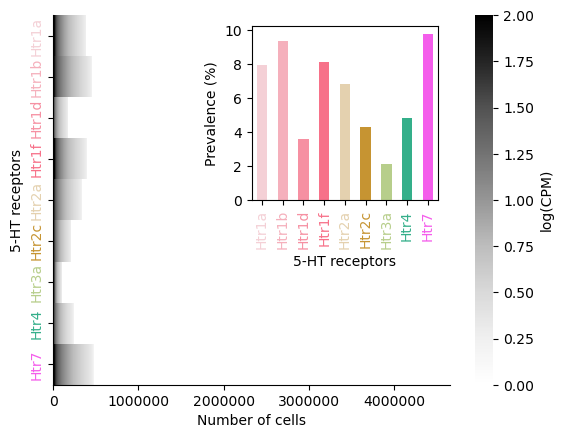

In [35]:
def expr_genes_whole_brain(ax_, exp):

    sns.heatmap(pd.DataFrame(np.sort(exp.values, axis=0)[::-20], columns=exp.columns, 
                                  index=exp.reset_index().index[::20]).T, xticklabels=50000, cbar_kws={'label': 'log(CPM)'}, cmap="Greys", ax=ax, vmax=2)
    ax.set_xlabel("Number of cells")
    ax.set_ylabel("5-HT receptors")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    
    colors_list = [genes_cmap_rgb[receptor] for receptor in exp.columns]
    
    for ytick in ax.get_yticklabels():
        ytick.set_color(genes_cmap_rgb[ytick.get_text()])
    
    axins = ax.inset_axes( [0.5, 0.5, 0.47, 0.47])
    (((exp>threshold_expression_MERFISH).sum(axis=0)/exp.shape[0])*100).plot.bar(ax=axins, color=colors_list)
    axins.set_xlabel("5-HT receptors")
    axins.set_ylabel("Prevalence (%)")
    
    for xtick in axins.get_xticklabels():
        xtick.set_color(genes_cmap_rgb[xtick.get_text()])

fig, ax = plt.subplots()
expr_genes_whole_brain(ax, exp_merfish)

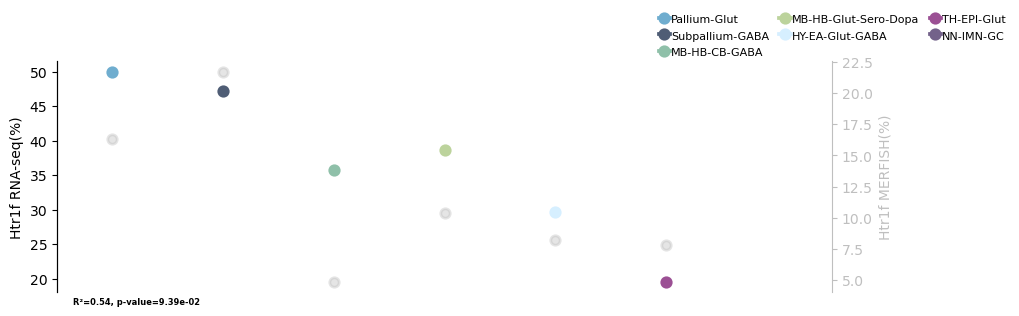

In [36]:
def receptor_prevalence(axs, gene, data, data_merfish=None):

    sns.pointplot(
    data=data, ax=axs, x="cluster_group_name", y=gene, hue="cluster_group_name", 
    palette=cluster_groups_cmap, order=[x for x in neuron_cluster_groups_order if x != 'NN-IMN-GC'], hue_order=neuron_cluster_groups_order, estimator=percentage_above_threshold, legend=1, errorbar=None)
        
    legend = axs.legend(loc='upper center', bbox_to_anchor=(1, 1.25), ncol=3, frameon=False, handlelength=1, handleheight=1, handletextpad =.1, columnspacing=.95, fontsize=8)
    sns.despine(ax=axs, bottom=True)
    if data_merfish is not None:
        
        axs2 = axs.twinx()
        sns.pointplot(
        data=data_merfish, ax=axs2, x="cluster_group_name", y=gene,  
        order=neuron_cluster_groups_order, estimator=percentage_above_threshold_MER, legend=0, errorbar=None, linestyle='', color=".75", alpha=.4)
    
        axs.set_ylabel(f"{gene} RNA-seq(%)")
        axs2.set_ylabel(f"{gene} MERFISH(%)")
        axs2.spines['right'].set_color(".75")
        axs2.yaxis.label.set_color(".75")
        axs2.tick_params(axis='y', colors=".75")
    
        r, p = pearsonr(data.groupby("cluster_group_name")[gene].apply(percentage_above_threshold), data_merfish.groupby("cluster_group_name")[gene].apply(percentage_above_threshold_MER))
        s,_,_,_,_=linregress(data.groupby("cluster_group_name")[gene].apply(percentage_above_threshold), data_merfish.groupby("cluster_group_name")[gene].apply(percentage_above_threshold_MER))
        
        plt.text(.02, -.05, f"R\u00b2={round(r ** 2, 2)}, p-value={'{:.2e}'.format(p)}", horizontalalignment='left',
                size=6, color='black', weight='semibold', transform = axs.transAxes, zorder=100)

        sns.despine(right=0, bottom=1, ax=axs2)
    
    axs.set_xticks([])  # This will remove the x-axis ticks
    axs.set_xticklabels([])  # This will remove the x-axis labels
    axs.set_xlabel("")  # This will remove the x-axis labels

fig, axs = plt.subplots(figsize=(10,3))
receptor_prevalence (axs, gene, joined_with_membership[joined_with_membership["cluster_group_name"]!="NN-IMN-GC"].reset_index(drop=True), data_merfish_with_membership[data_merfish_with_membership["cluster_group_name"]!="NN-IMN-GC"].reset_index(drop=True))

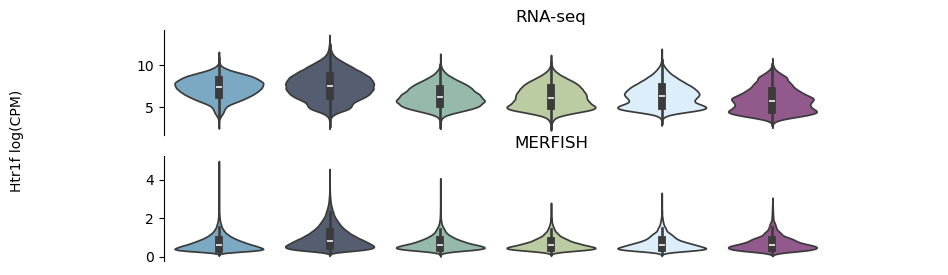

In [37]:
def receptor_expression(axs, gene, data, data_merfish):
    sns.violinplot(data=data, y=gene,x="cluster_group_name", hue="cluster_group_name" ,ax=axs[0], palette=cluster_groups_cmap,   order=neuron_cluster_groups_order, hue_order=neuron_cluster_groups_order)
    axs[0].tick_params(axis='x', rotation=45)
    axs[0].set_title("RNA-seq")
    
    sns.violinplot(data=data_merfish, y=gene,x="cluster_group_name", hue="cluster_group_name" ,ax=axs[1], palette=cluster_groups_cmap,   order=neuron_cluster_groups_order, hue_order=neuron_cluster_groups_order)
    axs[1].set_title("MERFISH")
    axs[1].tick_params(axis='x', rotation=45)
    plt.draw()

    for ax in axs:
        for ytick in ax.get_xticklabels():
            ytick.set_color(cluster_groups_cmap[ytick.get_text()])
        ax.set_xlabel("")
        ax.set_ylabel(f"{gene} log(CPM)")
        sns.despine(ax=ax, bottom=True)
        ax.set_xticks([])
        ax.set_xticklabels([])
        
    axs[0].set_ylabel("")
    axs[1].yaxis.set_label_coords(-.18, 1.15) 
fig, axs = plt.subplots(2, figsize=(10,3))
receptor_expression(axs, gene, joined_with_membership[(joined_with_membership["cluster_group_name"]!="NN-IMN-GC")&(joined_with_membership[gene]>0)], data_merfish_with_membership[(data_merfish_with_membership["cluster_group_name"]!="NN-IMN-GC")&(data_merfish_with_membership[gene]>0)])

In [38]:
def receptor_expression_no_merfish(axs, gene, data):
    sns.violinplot(data=data, y=gene,x="cluster_group_name", hue="cluster_group_name" ,ax=axs, palette=cluster_groups_cmap,   order=neuron_cluster_groups_order, hue_order=neuron_cluster_groups_order)
    axs.tick_params(axis='x', rotation=45)
    axs.set_title("RNA-seq")
    
    plt.draw()

    for ytick in axs.get_xticklabels():
        ytick.set_color(cluster_groups_cmap[ytick.get_text()])
    axs.set_xlabel("")
    axs.set_ylabel(f"{gene} log(CPM)")
    sns.despine(ax=axs, bottom=True)
    axs.set_xticks([])
    axs.set_xticklabels([])

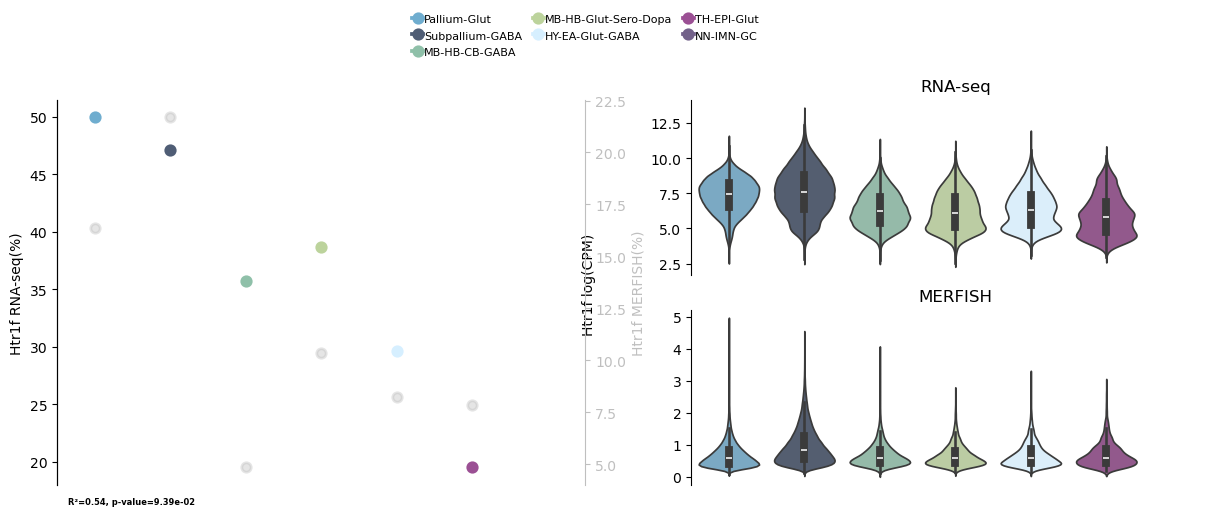

In [39]:
def plot_receptor_transcr_data(fig, gene):
    
    if gene in selected_genes_mer:
        
        ax1 = fig.add_subplot(121) # 1 row, 2 columns, 1st subplot
        ax2 = fig.add_subplot(222) # 2 rows, 2 columns, 2nd subplot
        ax3 = fig.add_subplot(224) # 2 rows, 2 columns, 4th subplot
        receptor_prevalence(ax1, gene, joined_with_membership[joined_with_membership["cluster_group_name"]!="NN-IMN-GC"].reset_index(drop=True), data_merfish_with_membership[data_merfish_with_membership["cluster_group_name"]!="NN-IMN-GC"].reset_index(drop=True))
        receptor_expression([ax2, ax3], gene, joined_with_membership[(joined_with_membership["cluster_group_name"]!="NN-IMN-GC")&(joined_with_membership[gene]>0)], data_merfish_with_membership[(data_merfish_with_membership["cluster_group_name"]!="NN-IMN-GC")&(data_merfish_with_membership[gene]>0)])
        sns.despine(ax=ax1, bottom=True)
        sns.despine(ax=ax2, bottom=True)
        sns.despine(ax=ax3, bottom=True)
    else:
        axs = fig.subplots(1,2)
        receptor_prevalence(axs[0], gene,  joined_with_membership[joined_with_membership["cluster_group_name"]!="NN-IMN-GC"].reset_index(drop=True))
        receptor_expression_no_merfish(axs[1], gene,  joined_with_membership[(joined_with_membership["cluster_group_name"]!="NN-IMN-GC")&(joined_with_membership[gene]>0)])
        sns.despine(ax=axs[0], bottom=True)
        sns.despine(ax=axs[1], bottom=True)

fig = plt.figure(figsize=(15, 5))
plot_receptor_transcr_data(fig, gene)

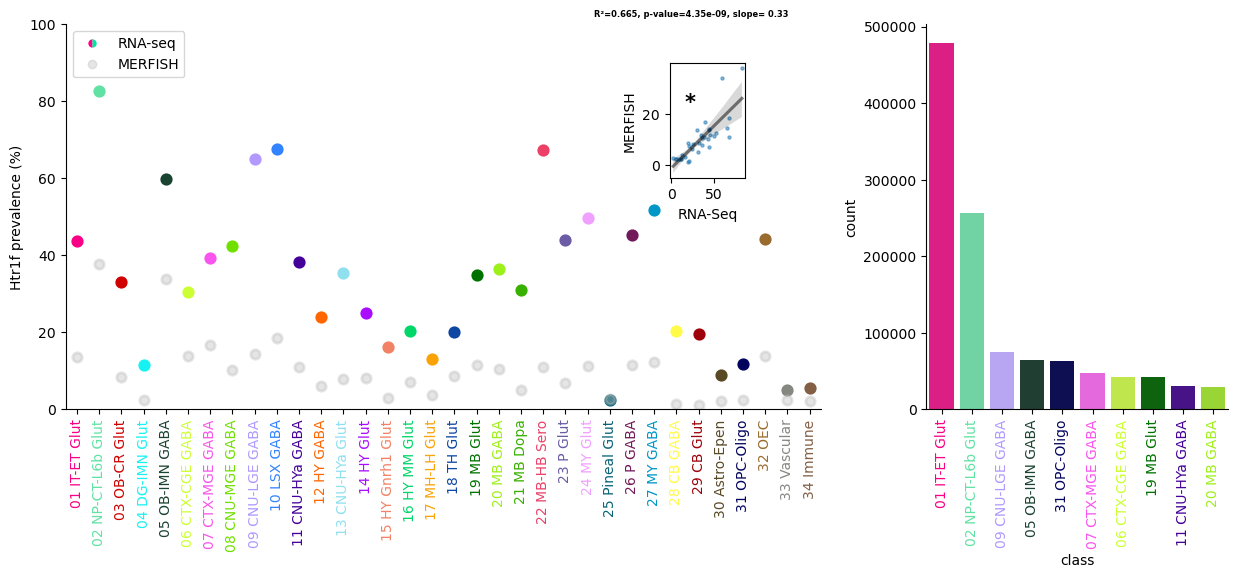

In [40]:
def plot_receptor_transcr_data_per_class(axs, gene):

    sns.pointplot(
    data=joined.reset_index(), 
    y=gene, hue="class", x="class", palette=classification_cmap, estimator=percentage_above_threshold, errorbar=None,
    ax=axs[0], order=joined["class"].sort_values().unique())

    plt.draw()
    
    for label in axs[0].get_xticklabels():
        label.set_rotation(90)
        label.set_color(classification_cmap[label.get_text()])
        #label.set_weight('bold')

    if gene in data_merfish.columns:
        sns.pointplot(
        data=data_merfish.reset_index(), 
        y=gene,x="class", estimator=percentage_above_threshold_MER, color=".75",  errorbar=None,linestyle='', alpha=.4,
        ax=axs[0], order=joined["class"].sort_values().unique())
        
        legend_labels = ['RNA-seq', 'MERFISH']
        legend_lines = [plt.Line2D([0], [0], markerfacecolor='#FF0089', fillstyle="left",
                               markerfacecoloralt='#00E69F', marker='o', linestyle='', markeredgewidth=0),
                        plt.Line2D([0], [0], color='.75', marker='o', linestyle='', alpha=.4)]
        axs[0].legend(handles=legend_lines, labels=legend_labels, loc=2)
    
        data = pd.concat([joined.groupby("class")[gene].apply(percentage_above_threshold), data_merfish.groupby("class")[gene].apply(percentage_above_threshold_MER)], axis=1)
        data.columns=["RNA-Seq", "MERFISH"]
    
        axins = axs[0].inset_axes( [0.8, 0.6, 0.1, 0.3])
        axins.patch.set_alpha(0)  
        
        sns.regplot(data=data, x="RNA-Seq", y= "MERFISH", ax=axins, scatter_kws={ "alpha": .5, 's':5}, line_kws={ "color": "k", "alpha": .5})
    
        r, p = pearsonr(data["RNA-Seq"], data["MERFISH"])

        s,_,_,_,_=linregress(data["RNA-Seq"], data["MERFISH"])
        
        plt.text(-1, 1.4, f"R\u00b2={round(r ** 2, 3)}, p-value={'{:.2e}'.format(p)}, slope= {round(s,2)}", horizontalalignment='left',
                size=6, color='black', weight='semibold', transform = axins.transAxes, zorder=100)
        if p<.05:
            plt.text(.2, .6, "*", size=15, color='black', weight='semibold', transform = axins.transAxes, zorder=10)

    axs[0].set_ylim((0,100))
    axs[0].set_ylabel(f'{gene} prevalence (%)')
    sns.despine(ax=axs[0])
    axs[0].set_xlabel("")

    _ = joined[joined[gene]>threshold_expression]["class"].value_counts().reset_index().iloc[:10]
    
    ax = sns.barplot(data=_, y="count", x="class", hue="class", palette=classification_cmap, ax=axs[1])
    axs[1].tick_params(axis='x', rotation=90)
    sns.despine(ax=axs[1])
    for label in axs[1].get_xticklabels():
        label.set_color(classification_cmap[label.get_text()])
    
fig, axs = plt.subplots(1,2, figsize=(15,5), width_ratios=[1,.4])
plot_receptor_transcr_data_per_class(axs, gene)

<Axes: ylabel='Colocalized (%)'>

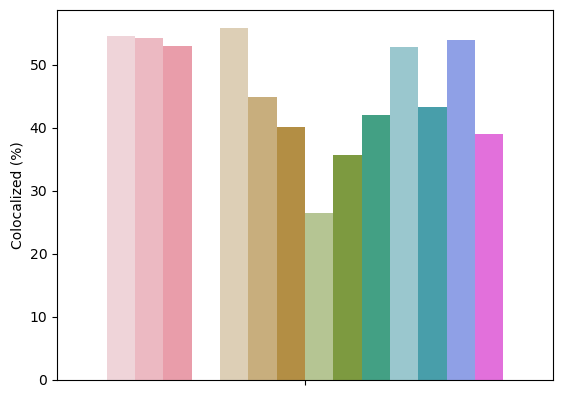

In [41]:
    sns.barplot(data=coloc[(coloc["Gene2"]==gene)&(coloc["Gene1"]!=gene)][["Gene1", "Colocalized (%)"]],  hue="Gene1", y="Colocalized (%)",  palette=genes_cmap, legend=0)

/tmp/ipykernel_860654/4034999425.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=coloc[(coloc["Gene1"]==gene)&(coloc["Gene2"]!=gene)][["Gene2", "Colocalized (%)"]], x="Gene2", legend=False, y="Colocalized (%)", ax=axs,  palette=genes_cmap)


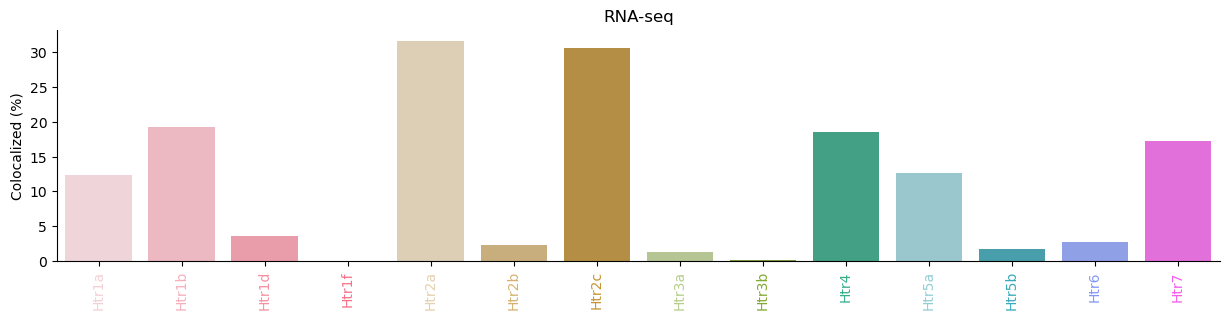

In [42]:
def barplot_coloc(axs, gene):
    
    sns.barplot(data=coloc[(coloc["Gene1"]==gene)&(coloc["Gene2"]!=gene)][["Gene2", "Colocalized (%)"]], x="Gene2", legend=False, y="Colocalized (%)", ax=axs,  palette=genes_cmap)
    axs.tick_params(axis='x', rotation=90)
    axs.set_xlabel("")

    #_ = joined_boolean[selected_genes]
    #axs.axhline(y=(np.sum(_[_[gene]==True].sum(axis=1)>1)/_[_[gene]==True].shape[0])*100, color='k', linestyle='--')
    axs.set_title("RNA-seq")
    #axs[1].set_title("MERFISH")
    #_ = pd.DataFrame(coloc_merfish[gene], columns=["Colocalized (%)"]).reset_index() 
    #sns.barplot(
    #    data=_,
    #     y="Colocalized (%)", x="index",hue="index", palette=genes_cmap, ax=axs[1]
    #)
    #axs[1].tick_params(axis='x', rotation=90)
    #axs[1].set_xlabel("")
    
    #_ = _["Colocalized (%)"]
    #axs[1].axhline(y=(_[_<100]).mean(), color='k', linestyle='--')
    
    plt.draw()

    for xtick in axs.get_xticklabels():
            xtick.set_color(genes_cmap[xtick.get_text()])
        
    sns.despine(ax=axs)
        
    #axs[0].set_ylabel("")
    #axs[1].yaxis.set_label_coords(-.1, 1.15) 
    
fig, axs = plt.subplots(1, figsize=(15,3))
barplot_coloc(axs, gene)

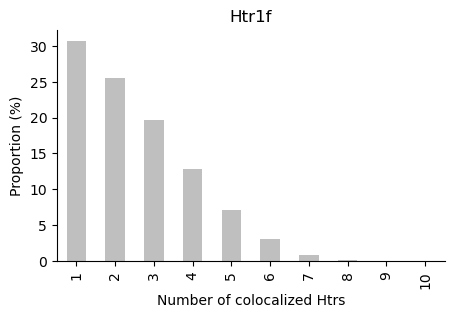

In [43]:
def plot_coloc_by_value(ax, gene): 
    _ = joined_boolean[selected_genes]
    (_[_[gene]==True].sum(axis=1).value_counts(normalize=True)).multiply(100).plot.bar(ax=ax, color=".75")
    ax.set_title(gene)
    ax.set_xlabel("Number of colocalized Htrs")
    ax.set_ylabel("Proportion (%)")
    sns.despine(ax=ax)
    
fig, axs = plt.subplots(1, figsize=(5,3))
plot_coloc_by_value(axs, gene)

In [44]:
#def barplot_coloc_by_class(axs, gene):
#    _ = pd.DataFrame(coloc[gene], columns=["Colocalized (%)"]).reset_index()
#
#    # Create the line plot
#    sns.barplot(data=pd.DataFrame.from_dict(coloc_per_class_and_gene[gene], orient="index", columns=["Colocalized (%)"]).reset_index(),x="index", hue="index",   ax=axs, y="Colocalized #(%)", order= data_merfish_cor["class"].sort_values().unique(),
#               palette=classification_cmap)
#
#    axs.set_xlabel("")
#    axs.set_ylabel("Colocalized (%)")
#    
#    axs.tick_params(axis='x', rotation=90)
#    
#    sns.despine(ax=axs)

#fig, axs = plt.subplots(1, figsize=(8,3))
#barplot_coloc_by_class(axs, gene)

In [45]:
# def plot_merfish_expr(axs, gene):
#     #filtered_data = data_merfish[(data_merfish['parcellation_category'] == "grey")&(data_merfish[gene] > 0)].groupby(['parcellation_division'])[gene].mean().reset_index()
#     #sorted_divisions = (filtered_data.groupby('parcellation_division')[gene].mean().sort_values(ascending=False).index)
    
#     #sns.barplot(data=filtered_data, x='parcellation_division', hue='parcellation_division', y=gene, palette=color_dict, order=sorted_divisions, ax=axs[1] )
#     #axs[1].tick_params(axis='x', rotation=90)
#     #axs[1].set_xlabel('')
#     #axs[1].set_ylabel(f"{gene} expression (log)")
    
#     filtered_data = data_merfish[data_merfish['parcellation_category'] == "grey"].groupby(['parcellation_division'])[gene].apply(percentage_above_threshold_MER).rename(f"{gene} prevalence (%)").reset_index()
#     sorted_divisions = (filtered_data.groupby('parcellation_division')[f"{gene} prevalence (%)"]
#                         .mean()
#                         .sort_values(ascending=False)
#                         .index)
#     sns.barplot(data=filtered_data, x='parcellation_division', hue='parcellation_division', y=f"{gene} prevalence (%)", palette=color_dict, order=sorted_divisions, ax=axs[0])
#     axs[0].tick_params(axis='x', rotation=90)
#     axs[0].set_xlabel('')
    
#     filtered_data = data_merfish[data_merfish['parcellation_category'] == "grey"].groupby(['parcellation_structure'])[gene].apply(percentage_above_threshold_MER).rename(f"{gene} prevalence (%)").reset_index().nlargest(10, f'{gene} prevalence (%)')
#     sorted_divisions = (filtered_data.groupby('parcellation_structure')[f"{gene} prevalence (%)"]
#                         .mean()
#                         .sort_values(ascending=False)
#                         .index)
#     sns.barplot(data=filtered_data, x='parcellation_structure', hue='parcellation_structure', y=f"{gene} prevalence (%)", palette=color_dict, order=sorted_divisions, ax=axs[1])
#     axs[1].tick_params(axis='x', rotation=90)
#     axs[1].set_xlabel('')
#     axs[1].set_title('Parcellation structure')
#     axs[0].set_title('Parcellation division')
#     for ax in axs:
#         sns.despine(ax=ax)
#     plt.draw()
#     for label in axs[0].get_xticklabels():
#         label.set_color(color_dict[label.get_text()])
#     for label in axs[1].get_xticklabels():
#         label.set_color(color_dict[label.get_text()])
        
# fig, axs = plt.subplots(1,2, figsize=(15,5))
# plot_merfish_expr(axs, gene)

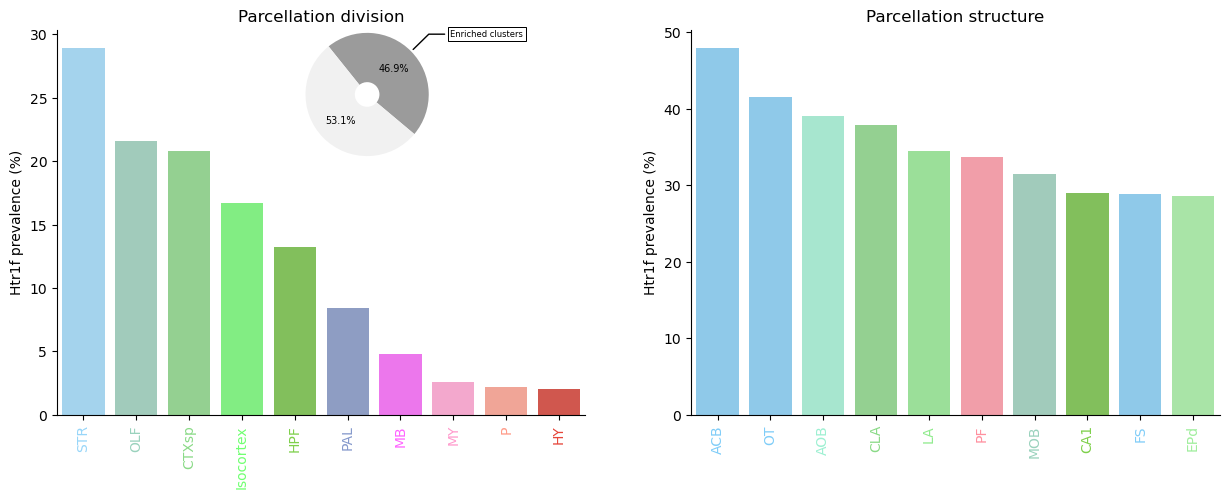

In [46]:
def plot_merfish_expr(axs, gene):
    clu_by_expr = joined.groupby("cluster")[gene].apply(percentage_above_threshold).sort_values(ascending=False)

    _ = ((data_merfish[(data_merfish["cluster"].isin(clu_by_expr[clu_by_expr>threshold_enriched_clusters].index))]
          .groupby('parcellation_division').size()/data_merfish.groupby('parcellation_division').size())*100).sort_values(ascending=False).reset_index().iloc[:10]
    _.columns=["parcellation_division", f"{gene} prevalence (%)"]

    sns.barplot(data=_, x='parcellation_division', hue='parcellation_division', y=f"{gene} prevalence (%)", palette=color_dict,  ax=axs[0])
    axs[0].tick_params(axis='x', rotation=90)
    axs[0].set_xlabel('')
    
    _ = ((data_merfish[(data_merfish["cluster"].isin(clu_by_expr[clu_by_expr>threshold_enriched_clusters].index))]
          .groupby('parcellation_structure').size()/data_merfish.groupby('parcellation_structure').size())*100).sort_values(ascending=False).reset_index().iloc[:10]
    _.columns=["parcellation_structure", f"{gene} prevalence (%)"]

    sns.barplot(data=_, x='parcellation_structure', hue='parcellation_structure', y=f"{gene} prevalence (%)", palette=color_dict,  ax=axs[1])
    axs[0].tick_params(axis='x', rotation=90)
    axs[0].set_xlabel('')
    
    
    axs[1].tick_params(axis='x', rotation=90)
    axs[1].set_xlabel('')
    axs[1].set_title('Parcellation structure')
    axs[0].set_title('Parcellation division')
    for ax in axs:
        sns.despine(ax=ax)
    plt.draw()
    for label in axs[0].get_xticklabels():
        label.set_color(color_dict[label.get_text()])
    for label in axs[1].get_xticklabels():
        label.set_color(color_dict[label.get_text()])

    ax_inset = inset_axes(axs[0], width="40%", height="40%", loc="upper right", bbox_to_anchor=(-.2, .05, 1, 1), bbox_transform=axs[0].transAxes)
    
    wedges, texts, ____ = ax_inset.pie(
        [joined_boolean[joined_boolean["cluster"].isin(clu_by_expr[clu_by_expr > threshold_enriched_clusters].index)][gene].sum() / joined_boolean[gene].sum(),
         1 - joined_boolean[joined_boolean["cluster"].isin(clu_by_expr[clu_by_expr > threshold_enriched_clusters].index)][gene].sum() / joined_boolean[gene].sum()],
        wedgeprops=dict(width=0.8), startangle=-40, autopct='%1.1f%%', colors=["#9B9B9B", "#F1F1F1"], textprops={'fontsize': 7}
    )

    recipe = ["Enriched clusters"]
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    kw = dict(arrowprops=dict(arrowstyle="-"), bbox=bbox_props, zorder=0, va="center", fontsize=6)

    for i, p in enumerate(wedges):
        if i == 0:
            ang = (p.theta2 - p.theta1) / 2. + p.theta1
            y = np.sin(np.deg2rad(ang))
            x = np.cos(np.deg2rad(ang))
            horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
            connectionstyle = "angle,angleA=0,angleB={}".format(ang)
            kw["arrowprops"].update({"connectionstyle": connectionstyle})
            ax_inset.annotate(recipe[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                        horizontalalignment=horizontalalignment, **kw)

fig, axs = plt.subplots(1,2, figsize=(15,5))
plot_merfish_expr(axs, gene)

In [47]:
# def lineplots_expr_vs_space(axs, section_colors, gene):

#     _ =  data_merfish_cor[data_merfish_cor[gene]>0]
#     sns.lineplot(data=_, x='brain_section_label', y=gene, ax=axs[0])
    
#     # Add colored vertical lines to the top plot
#     for section, color in section_colors.items():
#         axs[0].axvline(x=section, color=color)
#     sns.despine(ax=axs[0], bottom=True)
    
#     sns.lineplot(data=data_merfish_cor, x='brain_section_label', y=gene, ax=axs[1], estimator=percentage_above_threshold_MER)
    
#     for section, color in section_colors.items():
#         axs[1].axvline(x=section, color=color)
#     sns.despine(ax=axs[1], bottom=True)
    
#     for ax in axs:
#         ax.set_xticks([])  # Remove xticks
#         ax.set_xticklabels([])  # Remove xticklabels
#         ax.set_xlabel("")
#         ax.set_xlim([_['brain_section_label'].min(), _['brain_section_label'].max()])
        
#     axs[0].set_title(f"{gene} expression (log)",  fontsize=10)
#     axs[1].set_title(f"{gene} prevalence (%)", fontsize=10)
#     axs[0].set_ylabel("")
#     axs[1].set_ylabel("")
#     axs[1].set_ylabel("")
#     axs[1].axhline(y=0,color="k", linestyle='--')

#     # Add double-ended horizontal arrow
#     axs[0].annotate("anterior", xy=(-0.02, 1.18), xycoords='axes fraction', fontsize=10, ha="center")
#     axs[0].annotate("posterior", xy=(0.2, 1.18), xycoords='axes fraction', fontsize=10, ha="center")
#     axs[0].annotate("", xy=(0.02, 1.12), xycoords='axes fraction', xytext=(0.16, 1.12), textcoords='axes fraction',
#                 arrowprops=dict(arrowstyle="<->", color='black'))

# fig, axs = plt.subplots(2, figsize=(15,5))
# lineplots_expr_vs_space(axs, section_colors, gene)

Number enriched clusters: 879


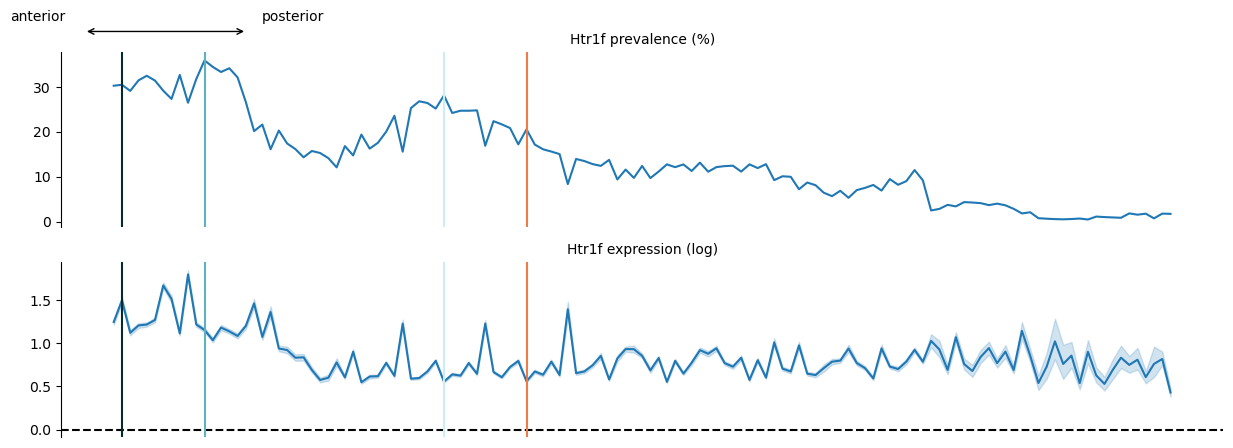

In [48]:
def lineplots_expr_vs_space(axs, gene, section_colors=None):
    if not isinstance(axs, (list, np.ndarray)):
        axs = [axs]

    gene_prev_clu = joined.groupby("cluster")[gene].apply(percentage_above_threshold).sort_values(ascending=False)
    print(f"Number enriched clusters: {gene_prev_clu[gene_prev_clu>threshold_enriched_clusters].shape[0]}")
    _ = ((data_merfish_cor[(data_merfish_cor["cluster"].isin(gene_prev_clu[gene_prev_clu>threshold_enriched_clusters].index))&(data_merfish_cor['parcellation_category'] == "grey")].groupby(['brain_section_label']).size()/data_merfish_cor[(data_merfish_cor['parcellation_category'] == "grey")].groupby(['brain_section_label']).size())*100).reset_index()
    _.columns=["brain_section_label", gene]
    
    sns.lineplot(data=_, x='brain_section_label', y=gene, ax=axs[0])
    
    sns.despine(ax=axs[0], bottom=True)

    if gene in data_merfish_cor.columns:
           
        gene_prev_clu = joined.groupby("cluster")[gene].apply(percentage_above_threshold).sort_values(ascending=False)
    
        _ = data_merfish_cor[(data_merfish_cor["cluster"].isin(gene_prev_clu[gene_prev_clu>threshold_enriched_clusters].index))&(data_merfish_cor['parcellation_category'] == "grey")][['brain_section_label', "x","y","z",  'parcellation_division_color','parcellation_division', gene]]
        _ =  _[_[gene]>0]
        
        sns.lineplot(data=_, x='brain_section_label', y=gene, ax=axs[1])
        axs[1].set_title(f"{gene} expression (log)", fontsize=10)
        axs[1].set_ylabel("")
        axs[1].set_ylabel("")
        axs[1].axhline(y=0,color="k", linestyle='--')
        sns.despine(ax=axs[1], bottom=True)

    if section_colors is not None:
        # Add colored vertical lines to the top plot
        for section, color in section_colors.items():
            for ax in axs:
                ax.axvline(x=section, color=color)
    
    for ax in axs:
        ax.set_xticks([])  # Remove xticks
        ax.set_xticklabels([])  # Remove xticklabels
        ax.set_xlabel("")
        #ax.set_xlim([_['brain_section_label'].min(), _['brain_section_label'].max()])
        
    axs[0].set_title(f"{gene} prevalence (%)",  fontsize=10)
    
    axs[0].set_ylabel("")
   
    # Add double-ended horizontal arrow
    axs[0].annotate("anterior", xy=(-0.02, 1.18), xycoords='axes fraction', fontsize=10, ha="center")
    axs[0].annotate("posterior", xy=(0.2, 1.18), xycoords='axes fraction', fontsize=10, ha="center")
    axs[0].annotate("", xy=(0.02, 1.12), xycoords='axes fraction', xytext=(0.16, 1.12), textcoords='axes fraction',
                arrowprops=dict(arrowstyle="<->", color='black'))
    
fig, axs = plt.subplots(2, figsize=(15,5))
lineplots_expr_vs_space(axs, gene, section_colors)

In [49]:
def plot_slice(ax, section, gene):
    ax.scatter(section["x"],section["y"],s=0.5, c=section[gene],marker='.',cmap=sns.color_palette("rocket_r", as_cmap=True))
    ax.scatter(-section["x"]+12,section["y"],s=0.5, c=section['parcellation_structure_color'],marker='.')
    ax.set_ylim(11,0)
    ax.set_xlim(0,11)
    ax.axis('equal')
    ax.set_xticks([])
    ax.set_yticks([])


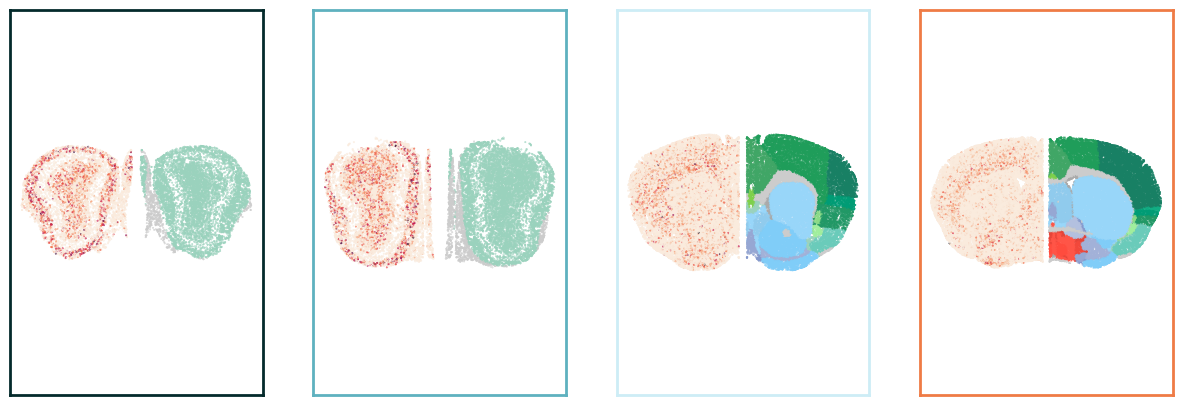

In [50]:
def plot_4_best_sections(axs, section_colors, gene):
    sections = list(section_colors.keys())
    # Below plots
    for i in range(len(section_colors)):
    
        section = data_merfish_cor[data_merfish_cor['brain_section_label'] == sections[i]]
        
        plot_slice(axs[i], section, gene)
        # Set the border color of the subplot
        for spine in axs[i].spines.values():
            spine.set_edgecolor(section_colors[sections[i]])
            spine.set_linewidth(2)  # adjust the width of the border as needed
        
fig, axs = plt.subplots(1,4, figsize=(15,5))

plot_4_best_sections(axs, section_colors, gene)

In [51]:
gene = "Htr1d"

In [52]:
def plot_figure(gene):
    fig = plt.figure(figsize=(10, 10))
    gs = gridspec.GridSpec(4, 4, height_ratios=[.7,1.3, .7,1])
    
    subfig = fig.add_subfigure(gs[0,:2])
    subfig.subplots_adjust(wspace=.7, hspace=.3, left=.05, bottom=0.05, top=.98, right=1.02)      
    subfig.suptitle("A", x=-.04, y=.95, fontsize=16, fontweight='bold');
    plot_receptor_transcr_data(subfig, gene)
    
    subfig = fig.add_subfigure(gs[0,2])
    axs = subfig.subplots()
    subfig.suptitle("B", x=.1, y=1.1, fontsize=16, fontweight='bold');
    subfig.subplots_adjust(hspace=.4, left=0.35, bottom=.2, top=.98, right=1)
    barplot_coloc(axs, gene)
    subfig.set_facecolor('none')

    subfig = fig.add_subfigure(gs[0,3])
    axs = subfig.subplots()
    subfig.subplots_adjust(hspace=.4, left=0.25, bottom=.2, top=.98, right=1)
    plot_coloc_by_value(axs, gene)

    subfig = fig.add_subfigure(gs[1,:4])
    axs = subfig.subplots(1,2, width_ratios=[1,.4])
    subfig.suptitle("C", x=-.02, y=1, fontsize=16, fontweight='bold');
    subfig.subplots_adjust(left=.05, bottom=.5, top=.9, right=1, wspace=.22)
    plot_receptor_transcr_data_per_class(axs, gene)
    subfig.set_facecolor('none')

    subfig.set_facecolor('none')

    gene_prev_clu = joined.groupby("cluster")[gene].apply(percentage_above_threshold).sort_values(ascending=False)
    
    s = (data_merfish_cor[(data_merfish_cor["cluster"].isin(gene_prev_clu[gene_prev_clu>threshold_enriched_clusters].index))&(data_merfish_cor['parcellation_category'] == "grey")].groupby(['brain_section_label']).size()/data_merfish_cor[(data_merfish_cor['parcellation_category'] == "grey")].groupby(['brain_section_label']).size())
    
    # Find the peaks that are at least 20 distance apart
    peaks, _ = find_peaks(s, distance=10)
    
    # Extract these peak values from the series
    peak_values = s.iloc[peaks].nlargest(4).sort_index()
            
    # Define a list of colors
    colors_peaks = ['#042A2B', '#5EB1BF', '#CDEDF6', '#EF7B45']
    
    # Initialize an empty dictionary for section_colors
    section_colors = {}
    
    # Assign colors to the available indices in peak_values
    for i in range(min(len(peak_values), len(colors_peaks))):
        section_colors[peak_values.index[i]] = colors_peaks[i]
    

    if gene in selected_genes_mer:


        subfig = fig.add_subfigure(gs[3,:])
        axs = subfig.subplots(1,len(section_colors))
        subfig.suptitle("F", x=-.02, y=.8, fontsize=16, fontweight='bold');
        subfig.subplots_adjust(left=0, bottom=.1, top=.8, right=1)
        plot_4_best_sections(axs, section_colors, gene)
        subfig.set_facecolor('none')

    if len(gene_prev_clu[gene_prev_clu>threshold_enriched_clusters]) > 0:
        subfig = fig.add_subfigure(gs[2,:2])
        axs = subfig.subplots(1,2)
        subfig.suptitle("D", x=0, y=1.1, fontsize=16, fontweight='bold');
        subfig.subplots_adjust(wspace=.35, left=0.05, bottom=.2, top=1, right=1)
        plot_merfish_expr(axs, gene)
        subfig.set_facecolor('none')

        subfig = fig.add_subfigure(gs[2,2:4])
        if gene in selected_genes_mer:
            axs = subfig.subplots(2)
            lineplots_expr_vs_space(axs, gene, section_colors)
        else:
            axs = subfig.subplots()  
            lineplots_expr_vs_space(axs, gene)
        subfig.suptitle("E", x=0, y=1.1, fontsize=16, fontweight='bold');
        subfig.subplots_adjust(hspace=0.2,left=0.1, bottom=.1, top=1, right=1)
        
    return fig

/tmp/ipykernel_860654/4034999425.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=coloc[(coloc["Gene1"]==gene)&(coloc["Gene2"]!=gene)][["Gene2", "Colocalized (%)"]], x="Gene2", legend=False, y="Colocalized (%)", ax=axs,  palette=genes_cmap)


Number enriched clusters: 24


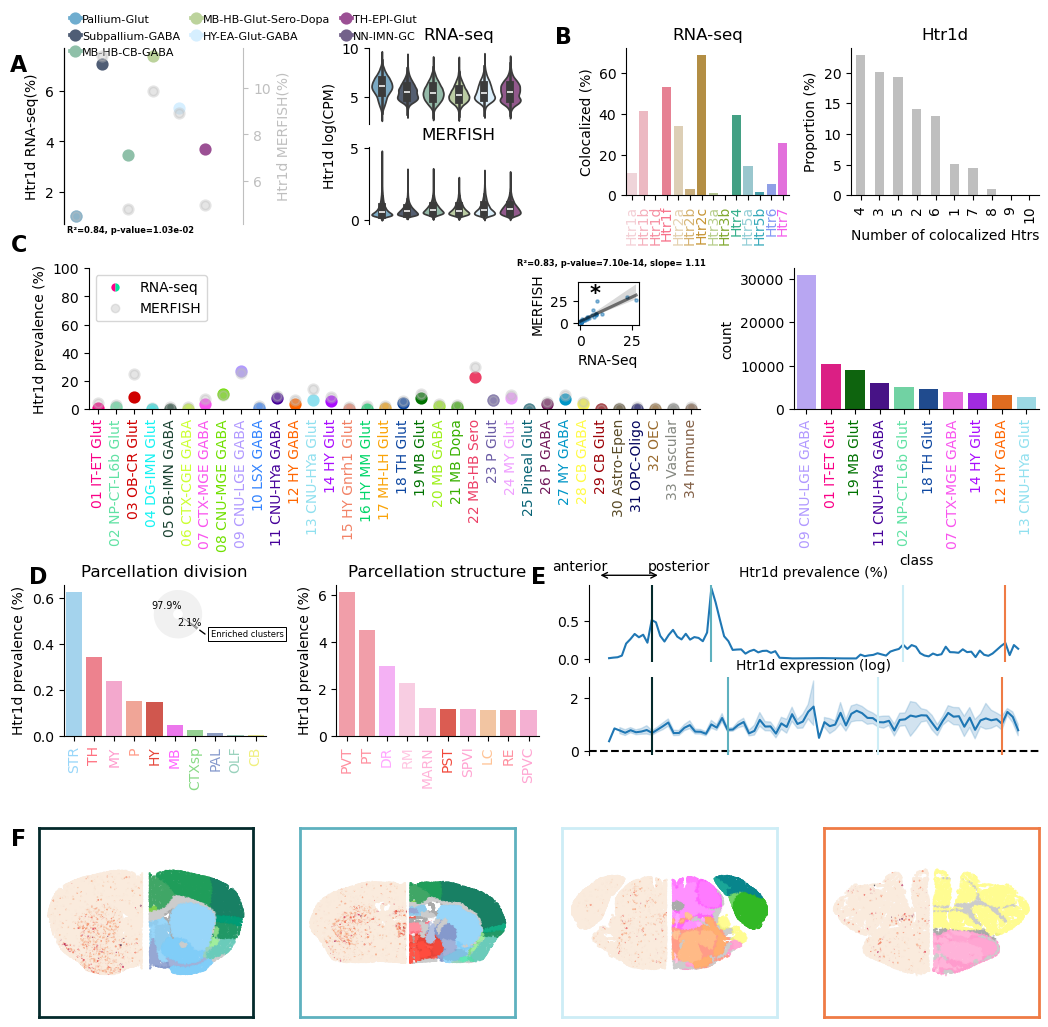

In [53]:
plot_figure(gene);

  0%|          | 0/14 [00:00<?, ?it/s]

Htr1a


/tmp/ipykernel_860654/4034999425.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=coloc[(coloc["Gene1"]==gene)&(coloc["Gene2"]!=gene)][["Gene2", "Colocalized (%)"]], x="Gene2", legend=False, y="Colocalized (%)", ax=axs,  palette=genes_cmap)


Number enriched clusters: 156
Htr1b


/tmp/ipykernel_860654/4034999425.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=coloc[(coloc["Gene1"]==gene)&(coloc["Gene2"]!=gene)][["Gene2", "Colocalized (%)"]], x="Gene2", legend=False, y="Colocalized (%)", ax=axs,  palette=genes_cmap)


Number enriched clusters: 358
Htr1d


/tmp/ipykernel_860654/4034999425.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=coloc[(coloc["Gene1"]==gene)&(coloc["Gene2"]!=gene)][["Gene2", "Colocalized (%)"]], x="Gene2", legend=False, y="Colocalized (%)", ax=axs,  palette=genes_cmap)


Number enriched clusters: 24
Htr1f


/tmp/ipykernel_860654/4034999425.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=coloc[(coloc["Gene1"]==gene)&(coloc["Gene2"]!=gene)][["Gene2", "Colocalized (%)"]], x="Gene2", legend=False, y="Colocalized (%)", ax=axs,  palette=genes_cmap)


Number enriched clusters: 879
Htr5a


/tmp/ipykernel_860654/4034999425.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=coloc[(coloc["Gene1"]==gene)&(coloc["Gene2"]!=gene)][["Gene2", "Colocalized (%)"]], x="Gene2", legend=False, y="Colocalized (%)", ax=axs,  palette=genes_cmap)


Number enriched clusters: 1
Htr5b


/tmp/ipykernel_860654/4034999425.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=coloc[(coloc["Gene1"]==gene)&(coloc["Gene2"]!=gene)][["Gene2", "Colocalized (%)"]], x="Gene2", legend=False, y="Colocalized (%)", ax=axs,  palette=genes_cmap)


Number enriched clusters: 10
Htr2a


/tmp/ipykernel_860654/4034999425.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=coloc[(coloc["Gene1"]==gene)&(coloc["Gene2"]!=gene)][["Gene2", "Colocalized (%)"]], x="Gene2", legend=False, y="Colocalized (%)", ax=axs,  palette=genes_cmap)


Number enriched clusters: 384
Htr2b


/tmp/ipykernel_860654/4034999425.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=coloc[(coloc["Gene1"]==gene)&(coloc["Gene2"]!=gene)][["Gene2", "Colocalized (%)"]], x="Gene2", legend=False, y="Colocalized (%)", ax=axs,  palette=genes_cmap)


Htr2c


/tmp/ipykernel_860654/4034999425.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=coloc[(coloc["Gene1"]==gene)&(coloc["Gene2"]!=gene)][["Gene2", "Colocalized (%)"]], x="Gene2", legend=False, y="Colocalized (%)", ax=axs,  palette=genes_cmap)


Number enriched clusters: 2798
Htr4


/tmp/ipykernel_860654/4034999425.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=coloc[(coloc["Gene1"]==gene)&(coloc["Gene2"]!=gene)][["Gene2", "Colocalized (%)"]], x="Gene2", legend=False, y="Colocalized (%)", ax=axs,  palette=genes_cmap)


Number enriched clusters: 1178
Htr6


/tmp/ipykernel_860654/4034999425.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=coloc[(coloc["Gene1"]==gene)&(coloc["Gene2"]!=gene)][["Gene2", "Colocalized (%)"]], x="Gene2", legend=False, y="Colocalized (%)", ax=axs,  palette=genes_cmap)


Htr7


/tmp/ipykernel_860654/4034999425.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=coloc[(coloc["Gene1"]==gene)&(coloc["Gene2"]!=gene)][["Gene2", "Colocalized (%)"]], x="Gene2", legend=False, y="Colocalized (%)", ax=axs,  palette=genes_cmap)


Number enriched clusters: 1103
Htr3a


/tmp/ipykernel_860654/4034999425.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=coloc[(coloc["Gene1"]==gene)&(coloc["Gene2"]!=gene)][["Gene2", "Colocalized (%)"]], x="Gene2", legend=False, y="Colocalized (%)", ax=axs,  palette=genes_cmap)


Number enriched clusters: 47
Htr3b


/tmp/ipykernel_860654/4034999425.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=coloc[(coloc["Gene1"]==gene)&(coloc["Gene2"]!=gene)][["Gene2", "Colocalized (%)"]], x="Gene2", legend=False, y="Colocalized (%)", ax=axs,  palette=genes_cmap)


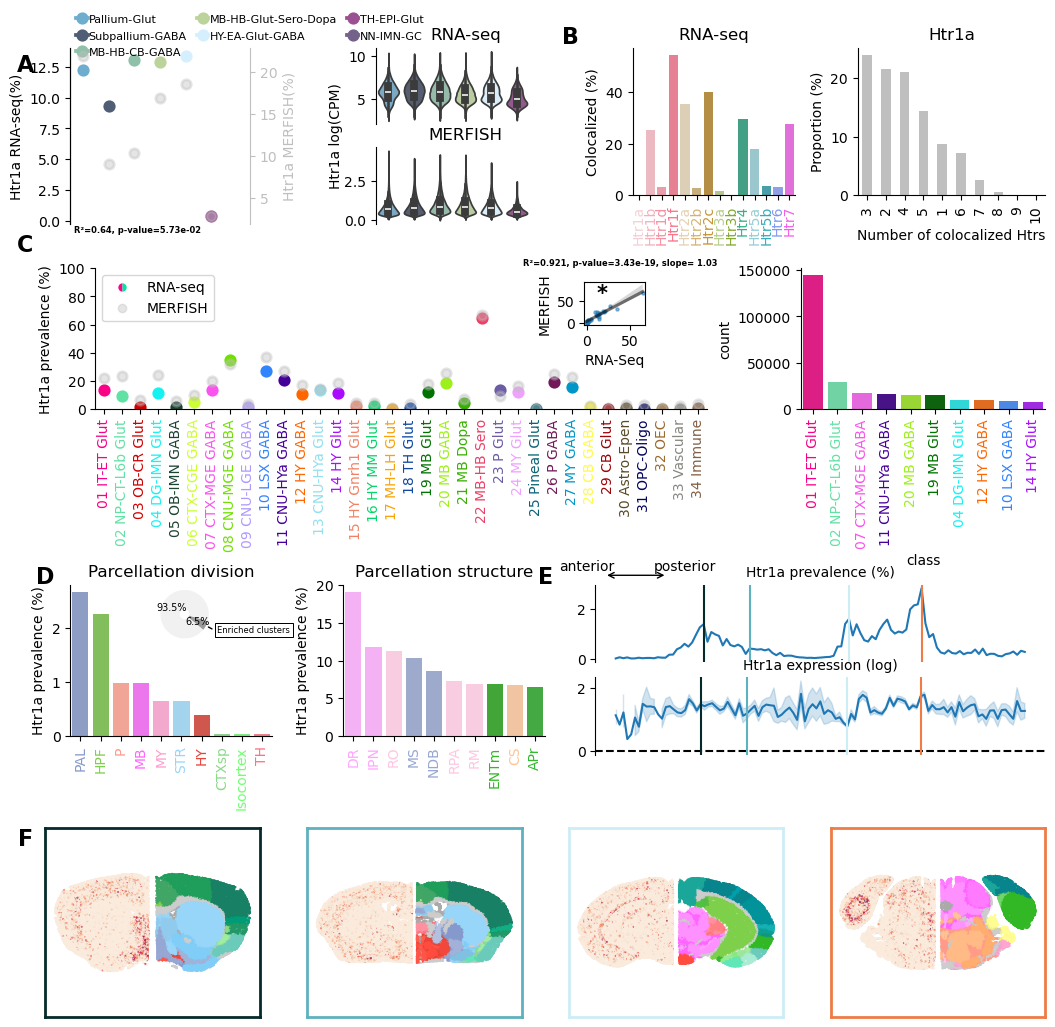

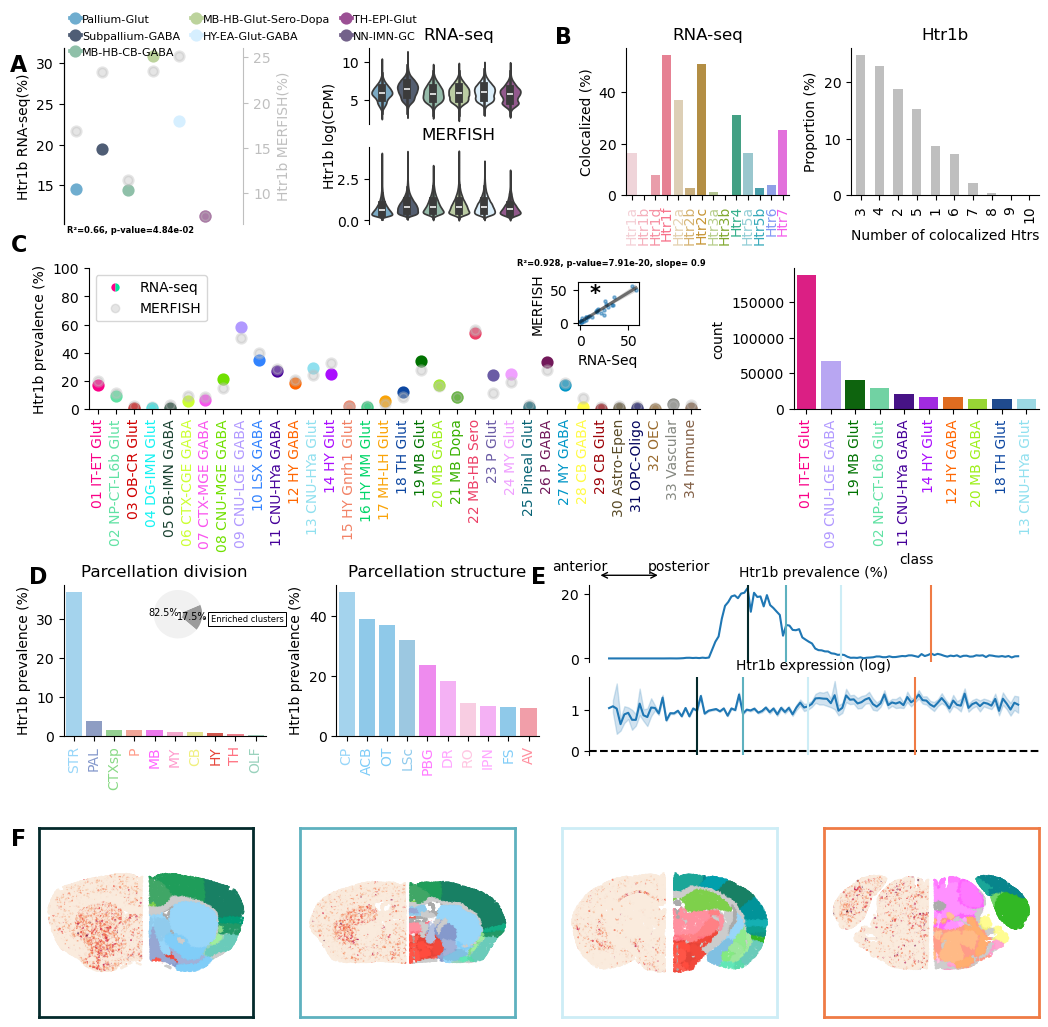

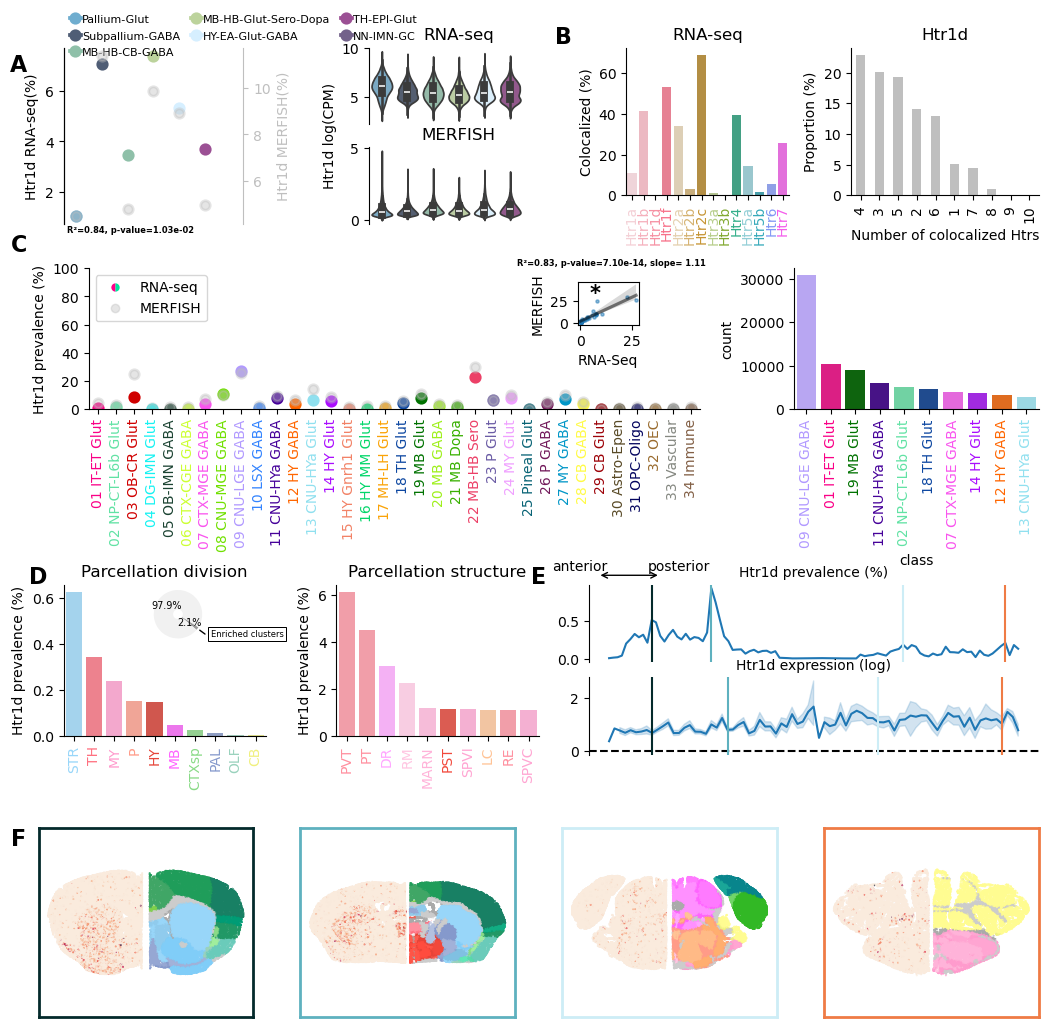

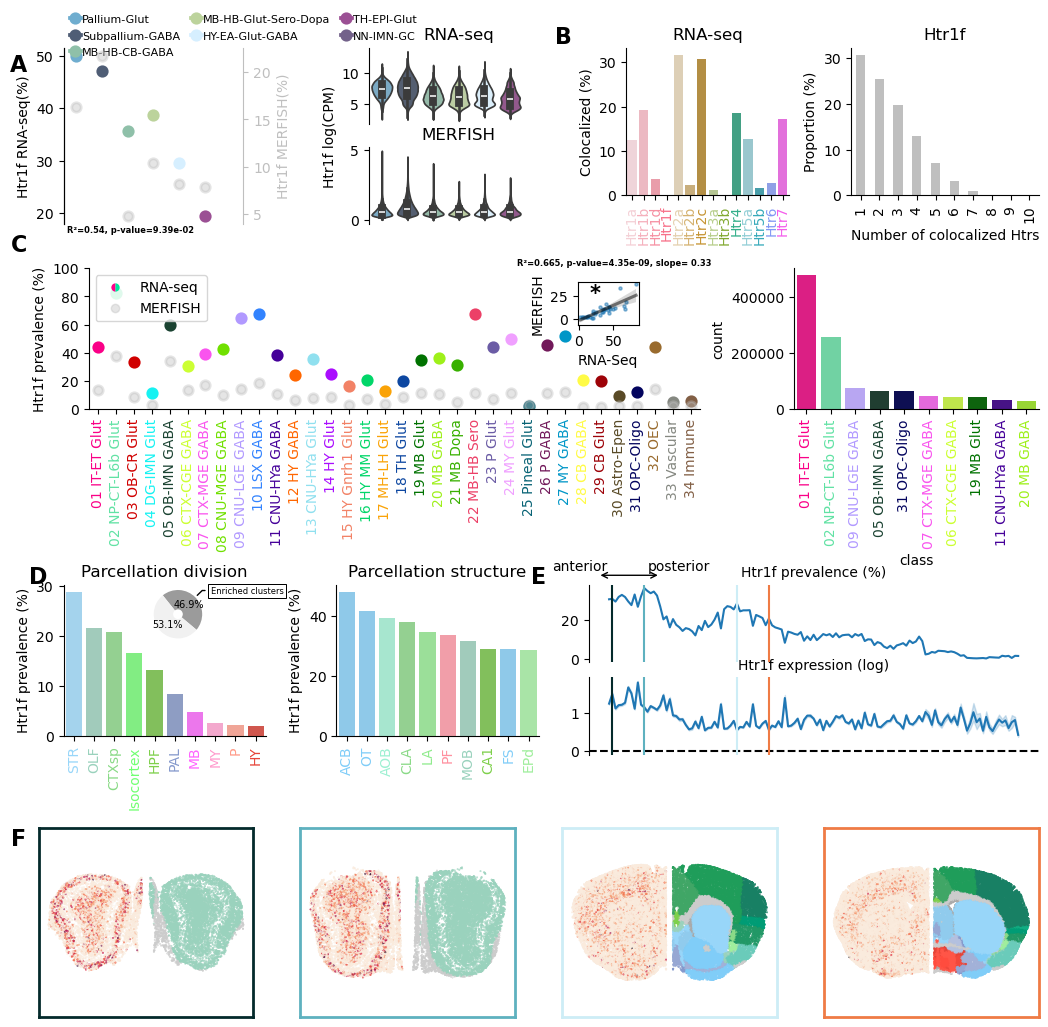

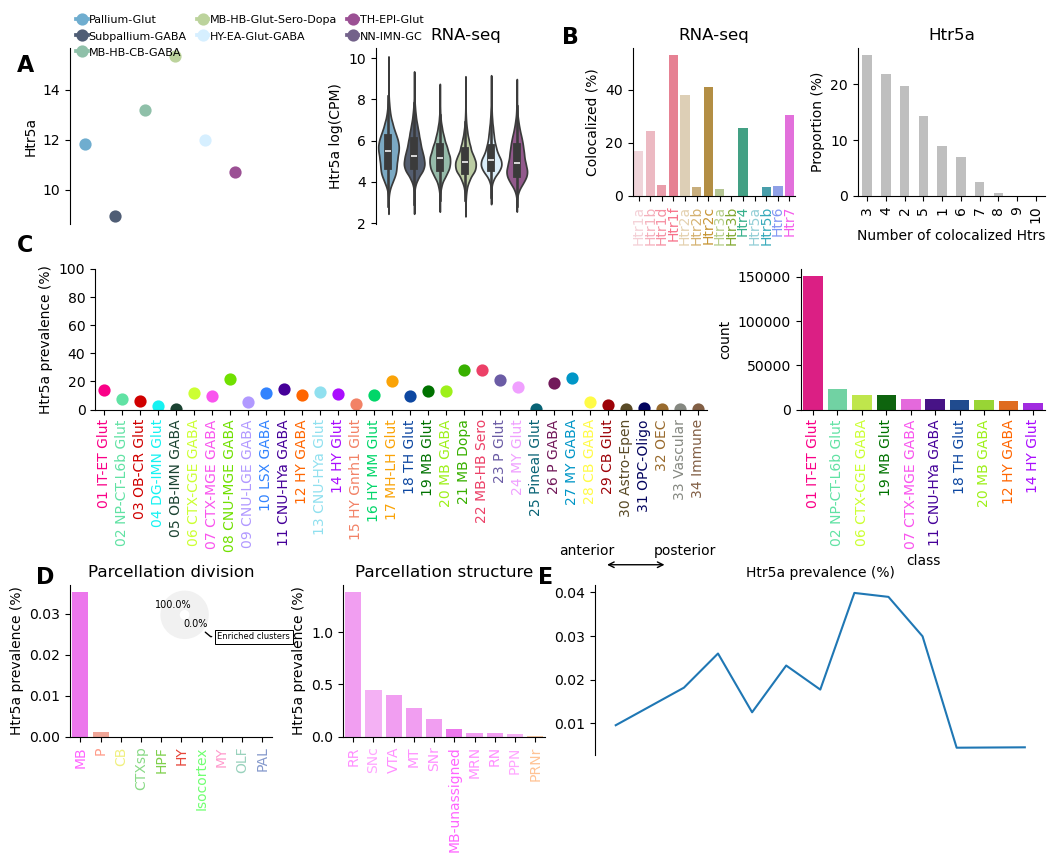

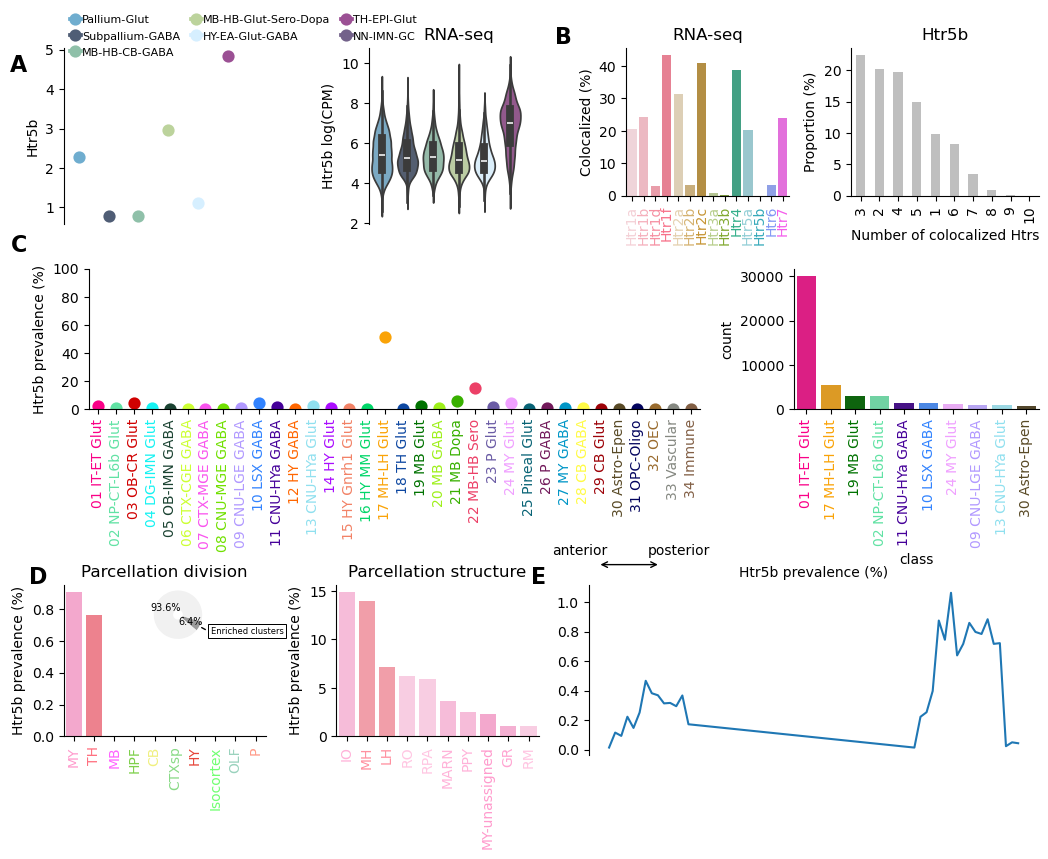

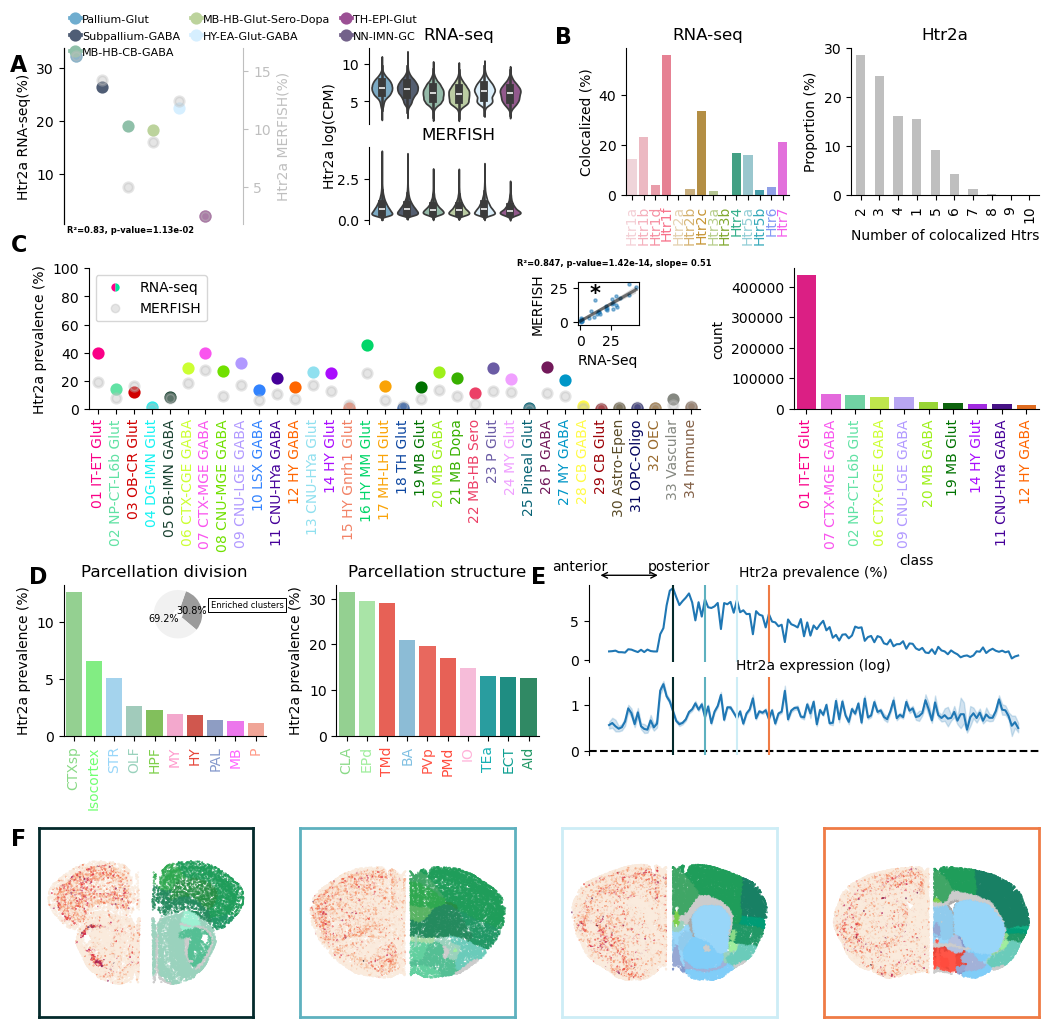

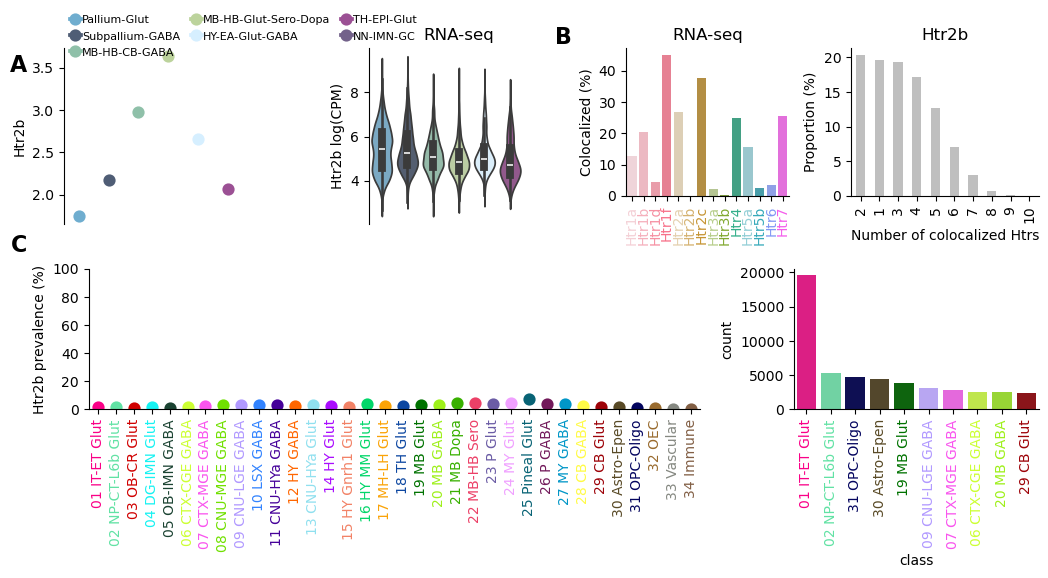

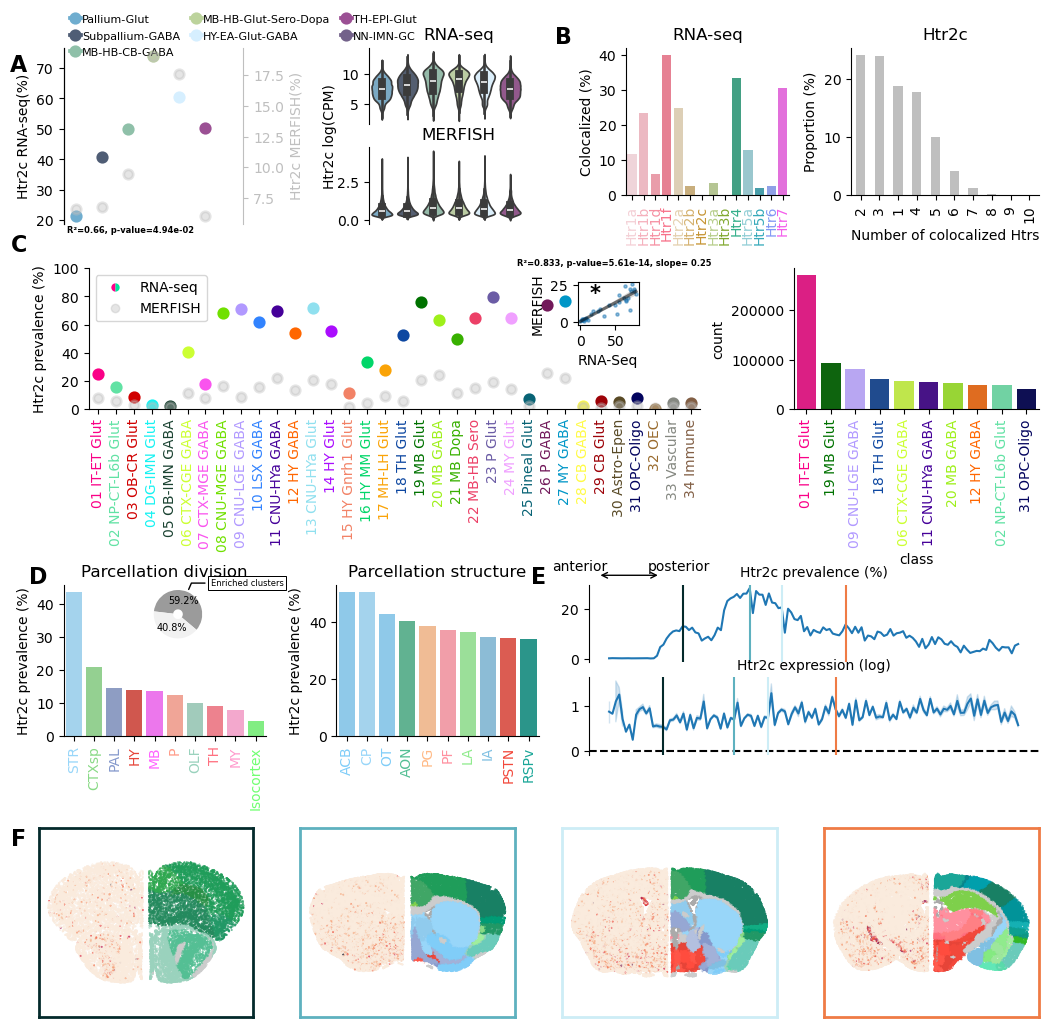

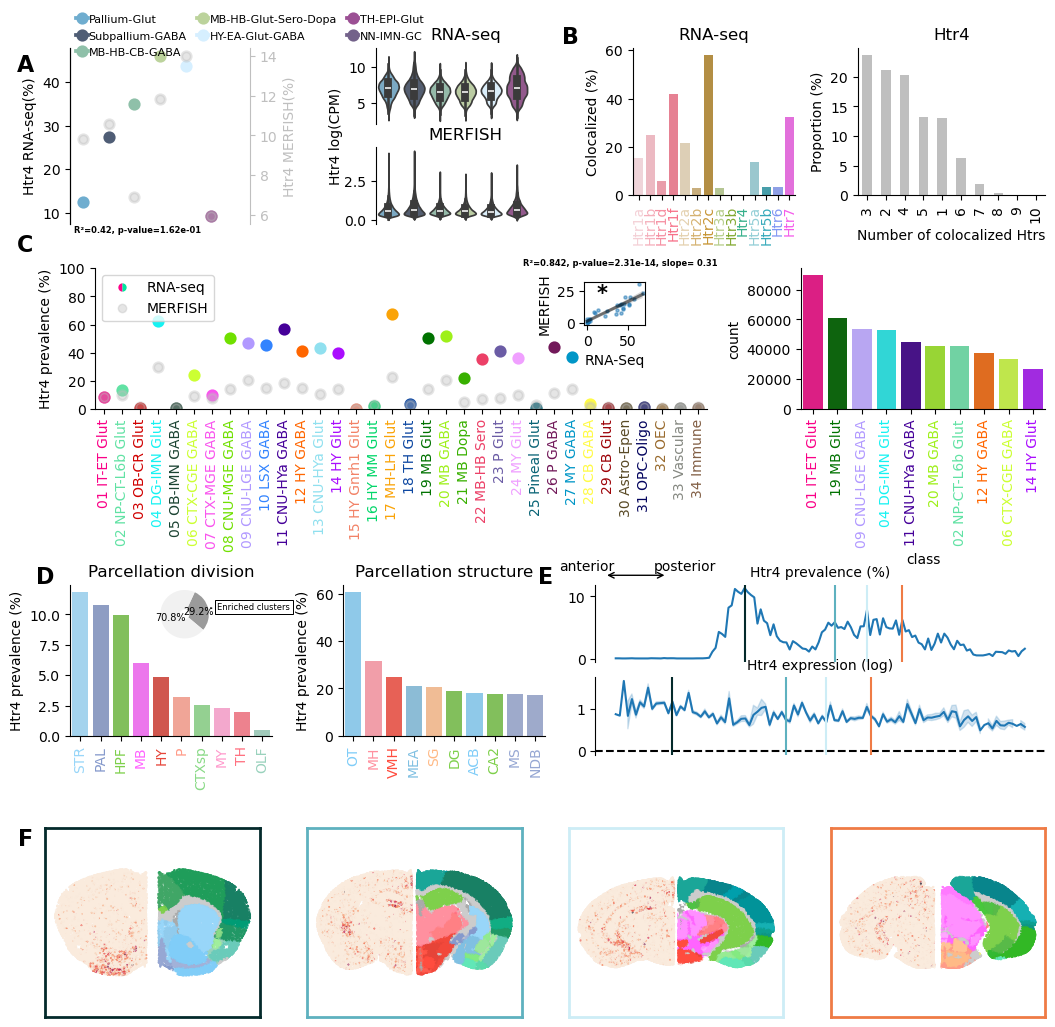

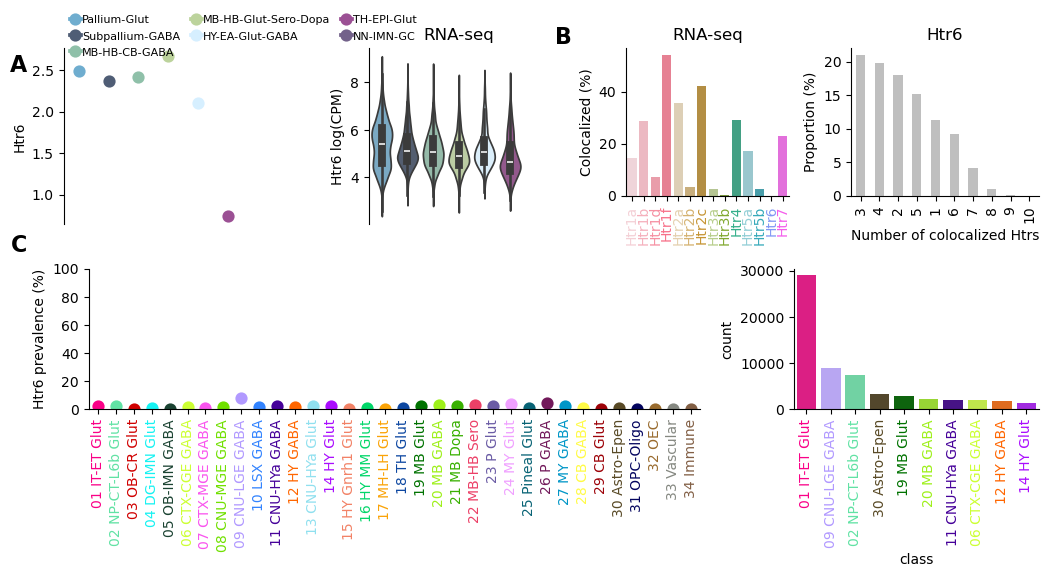

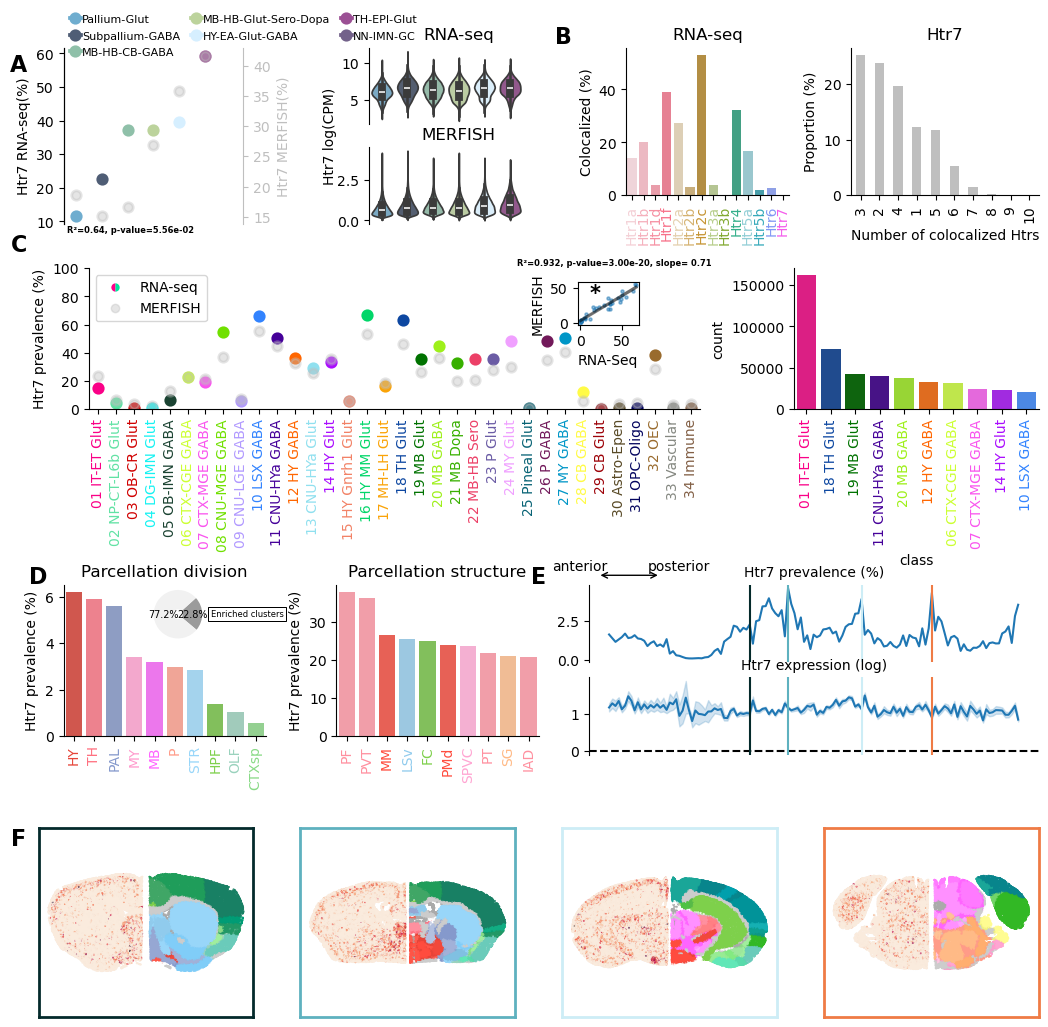

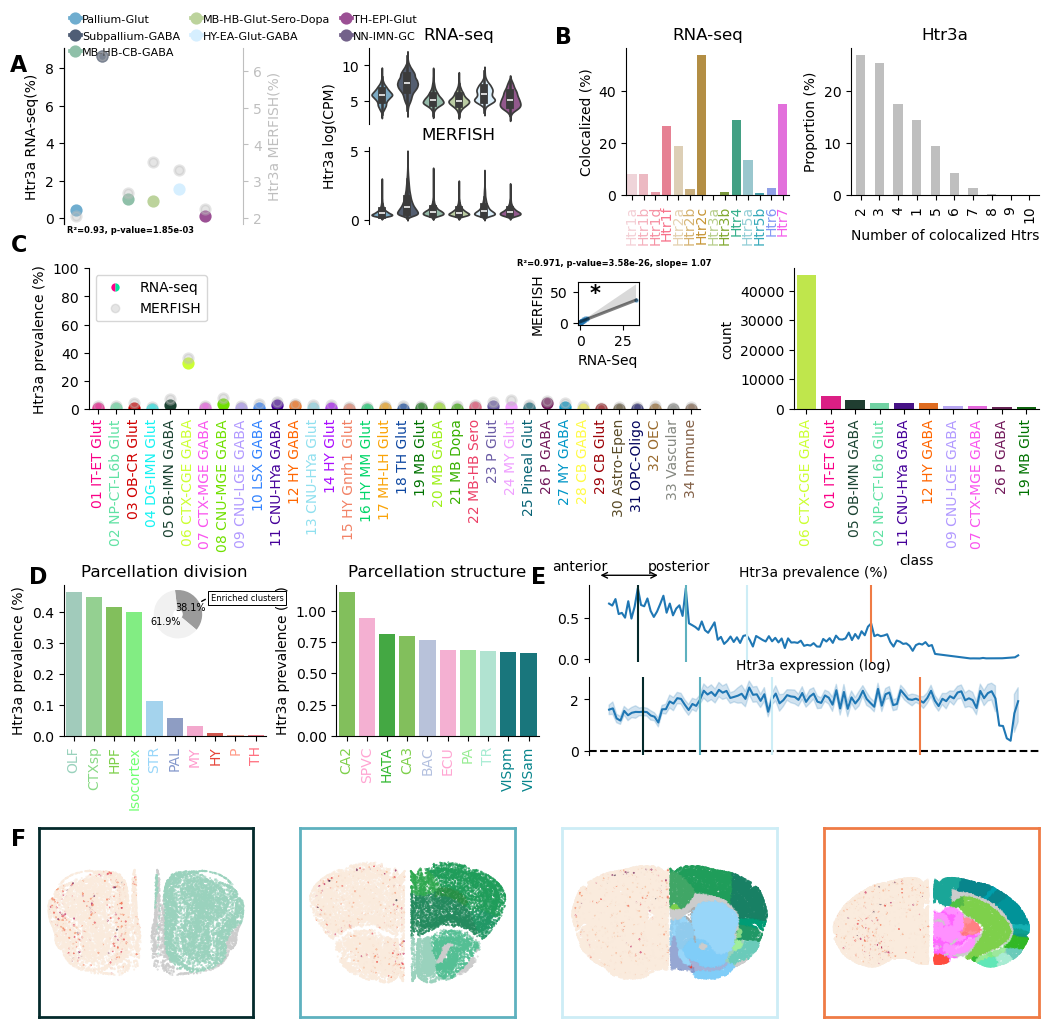

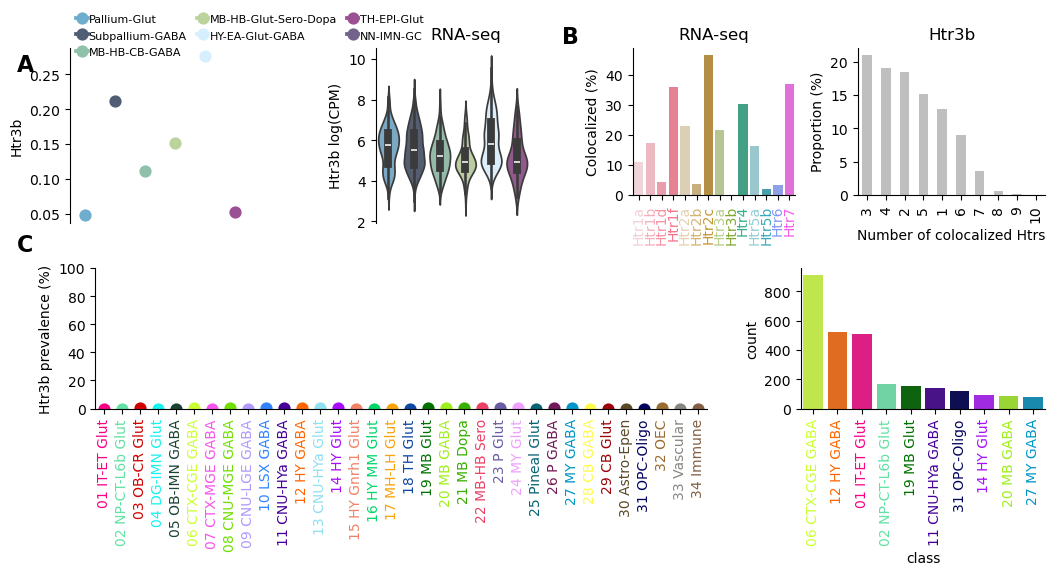

In [54]:
n=2
nn=5
for gene in tqdm(['Htr1a', 'Htr1b', 'Htr1d', 'Htr1f', 'Htr5a', 'Htr5b', 'Htr2a', 'Htr2b', 'Htr2c', 'Htr4', 'Htr6', 'Htr7', 'Htr3a',
       'Htr3b']):
    print(gene)
    fig = plot_figure(gene)
    if gene in ['Htr1a', 'Htr1b', 'Htr1f', 'Htr2a', 'Htr2c',
      'Htr4', 'Htr7']:
        fig.savefig(Path(output_folder, f'Figure_{n}.png'), bbox_inches='tight', dpi=300)
        n=n+1
    else:
        fig.savefig(Path(output_folder, f'Supp_Figure_{nn}.png'), bbox_inches='tight', dpi=300)
        nn=nn+1
    

In [55]:
data_merfish["parcellation_division"] = pd.Categorical(data_merfish["parcellation_division"], categories=order_division, ordered=True)

In [56]:
out = []
for gene in tqdm(selected_genes):
    gene_prev_clu = joined.groupby("cluster")[gene].apply(percentage_above_threshold).sort_values(ascending=False)
    
    _ = (data_merfish[(data_merfish["cluster"].isin(gene_prev_clu[gene_prev_clu>threshold_enriched_clusters].index))].groupby(['parcellation_division', 'parcellation_structure'],observed=True).size()/data_merfish.groupby(['parcellation_division', 'parcellation_structure'],observed=True).size())*100
    _.name=gene
    out.append(_)

expr_by_region = pd.concat(out, axis=1).fillna(0)



out = []
for gene in tqdm(selected_genes):
    gene_prev_clu = joined[joined["neurotransmitter"].isin(['Glut'])].groupby("cluster")[gene].apply(percentage_above_threshold).sort_values(ascending=False)
    sel_clu = joined[joined["neurotransmitter"].isin(['Glut'])]["cluster"]
    
    _ = (data_merfish[(data_merfish["cluster"].isin(gene_prev_clu[gene_prev_clu>threshold_enriched_clusters].index))].groupby(['parcellation_division', 'parcellation_structure'],observed=True).size()/data_merfish[(data_merfish["cluster"].isin(sel_clu))].groupby(['parcellation_division', 'parcellation_structure'],observed=True).size())*100
    _.name=gene
    out.append(_)

expr_by_region_glut = pd.concat(out, axis=1).fillna(0)

out = []
for gene in tqdm(selected_genes):
    gene_prev_clu = joined[joined["neurotransmitter"].isin(['GABA', "GABA-Glyc"])].groupby("cluster")[gene].apply(percentage_above_threshold).sort_values(ascending=False)
    sel_clu = joined[joined["neurotransmitter"].isin(['GABA', "GABA-Glyc"])]["cluster"]
    
    _ = (data_merfish[(data_merfish["cluster"].isin(gene_prev_clu[gene_prev_clu>threshold_enriched_clusters].index))].groupby(['parcellation_division', 'parcellation_structure'],observed=True).size()/data_merfish[(data_merfish["cluster"].isin(sel_clu))].groupby(['parcellation_division', 'parcellation_structure'],observed=True).size())*100
    _.name=gene
    out.append(_)

expr_by_region_gaba = pd.concat(out, axis=1).fillna(0)

dict_expr_by_reg = {"Tot":expr_by_region, "Glut": expr_by_region_glut, "Gaba": expr_by_region_gaba}

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

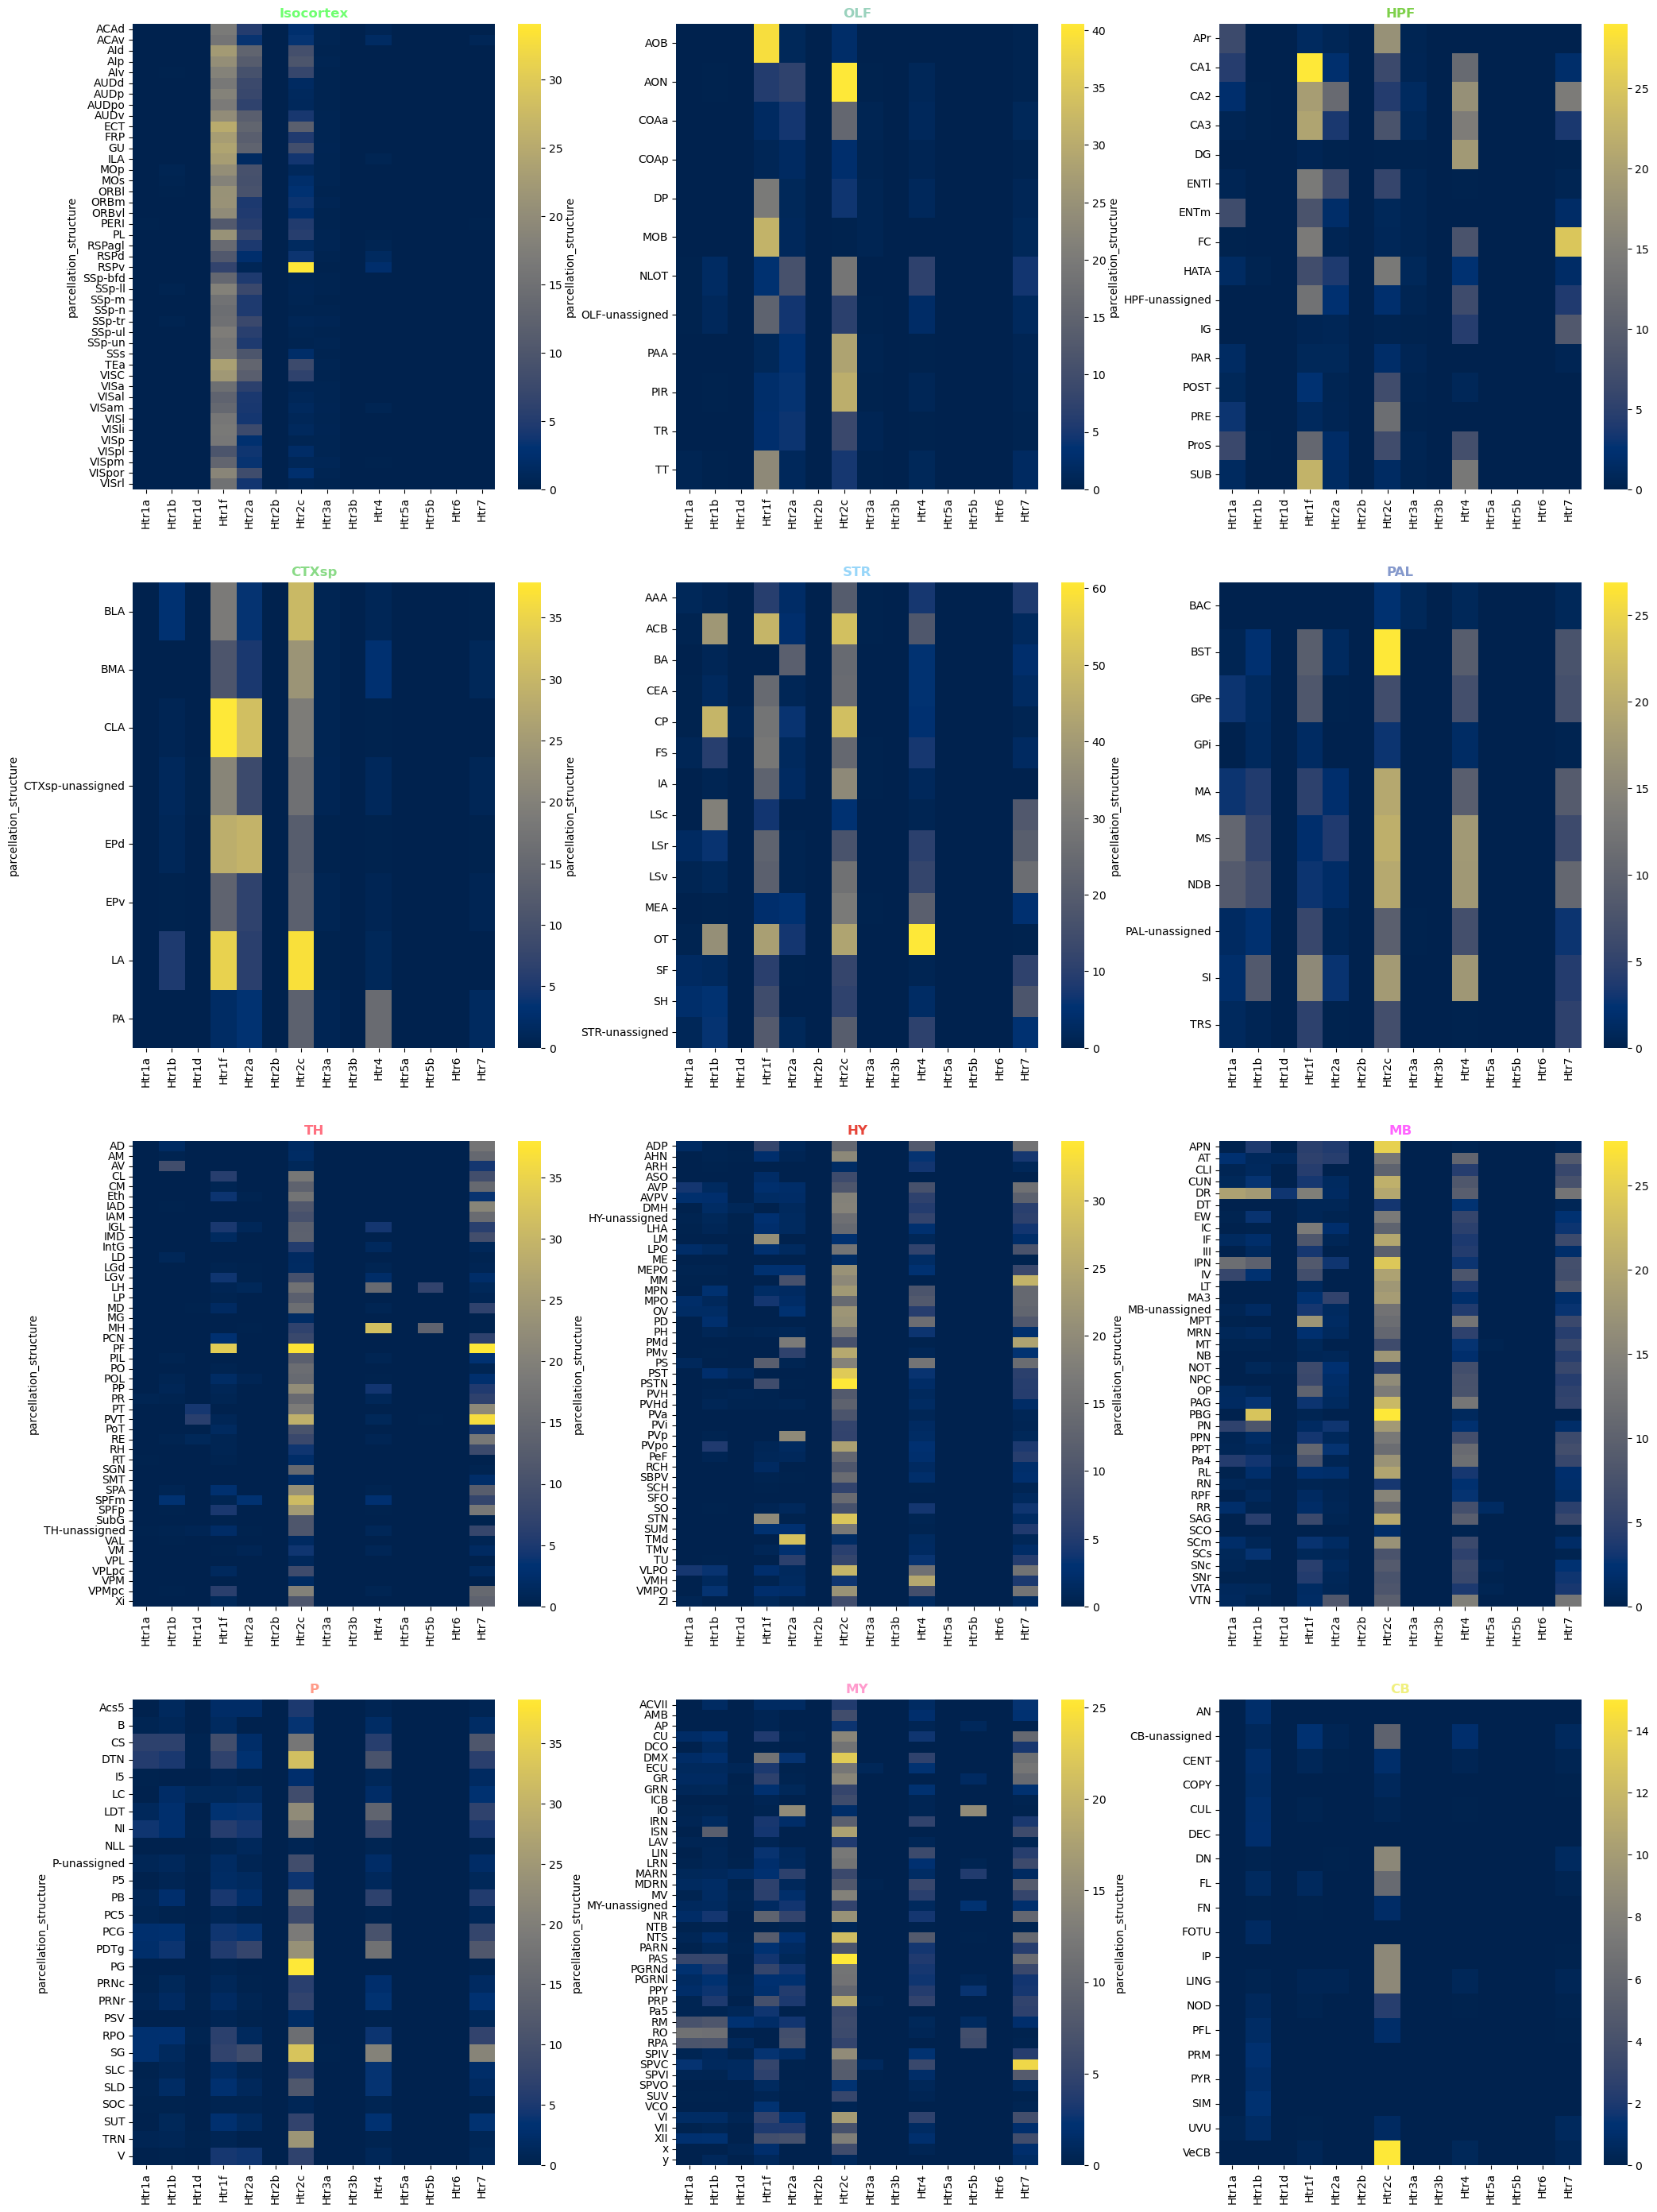

In [57]:
fig, axs = plt.subplots(4,3, figsize=(25,35))

axs_flat = axs.flatten()

for n, reg in enumerate(order_division):
    sns.heatmap(expr_by_region.loc[reg], cmap="cividis", ax=axs_flat[n], yticklabels=1)
    axs_flat[n].set_title(reg, color=color_dict[reg], fontsize='large', fontweight='bold')

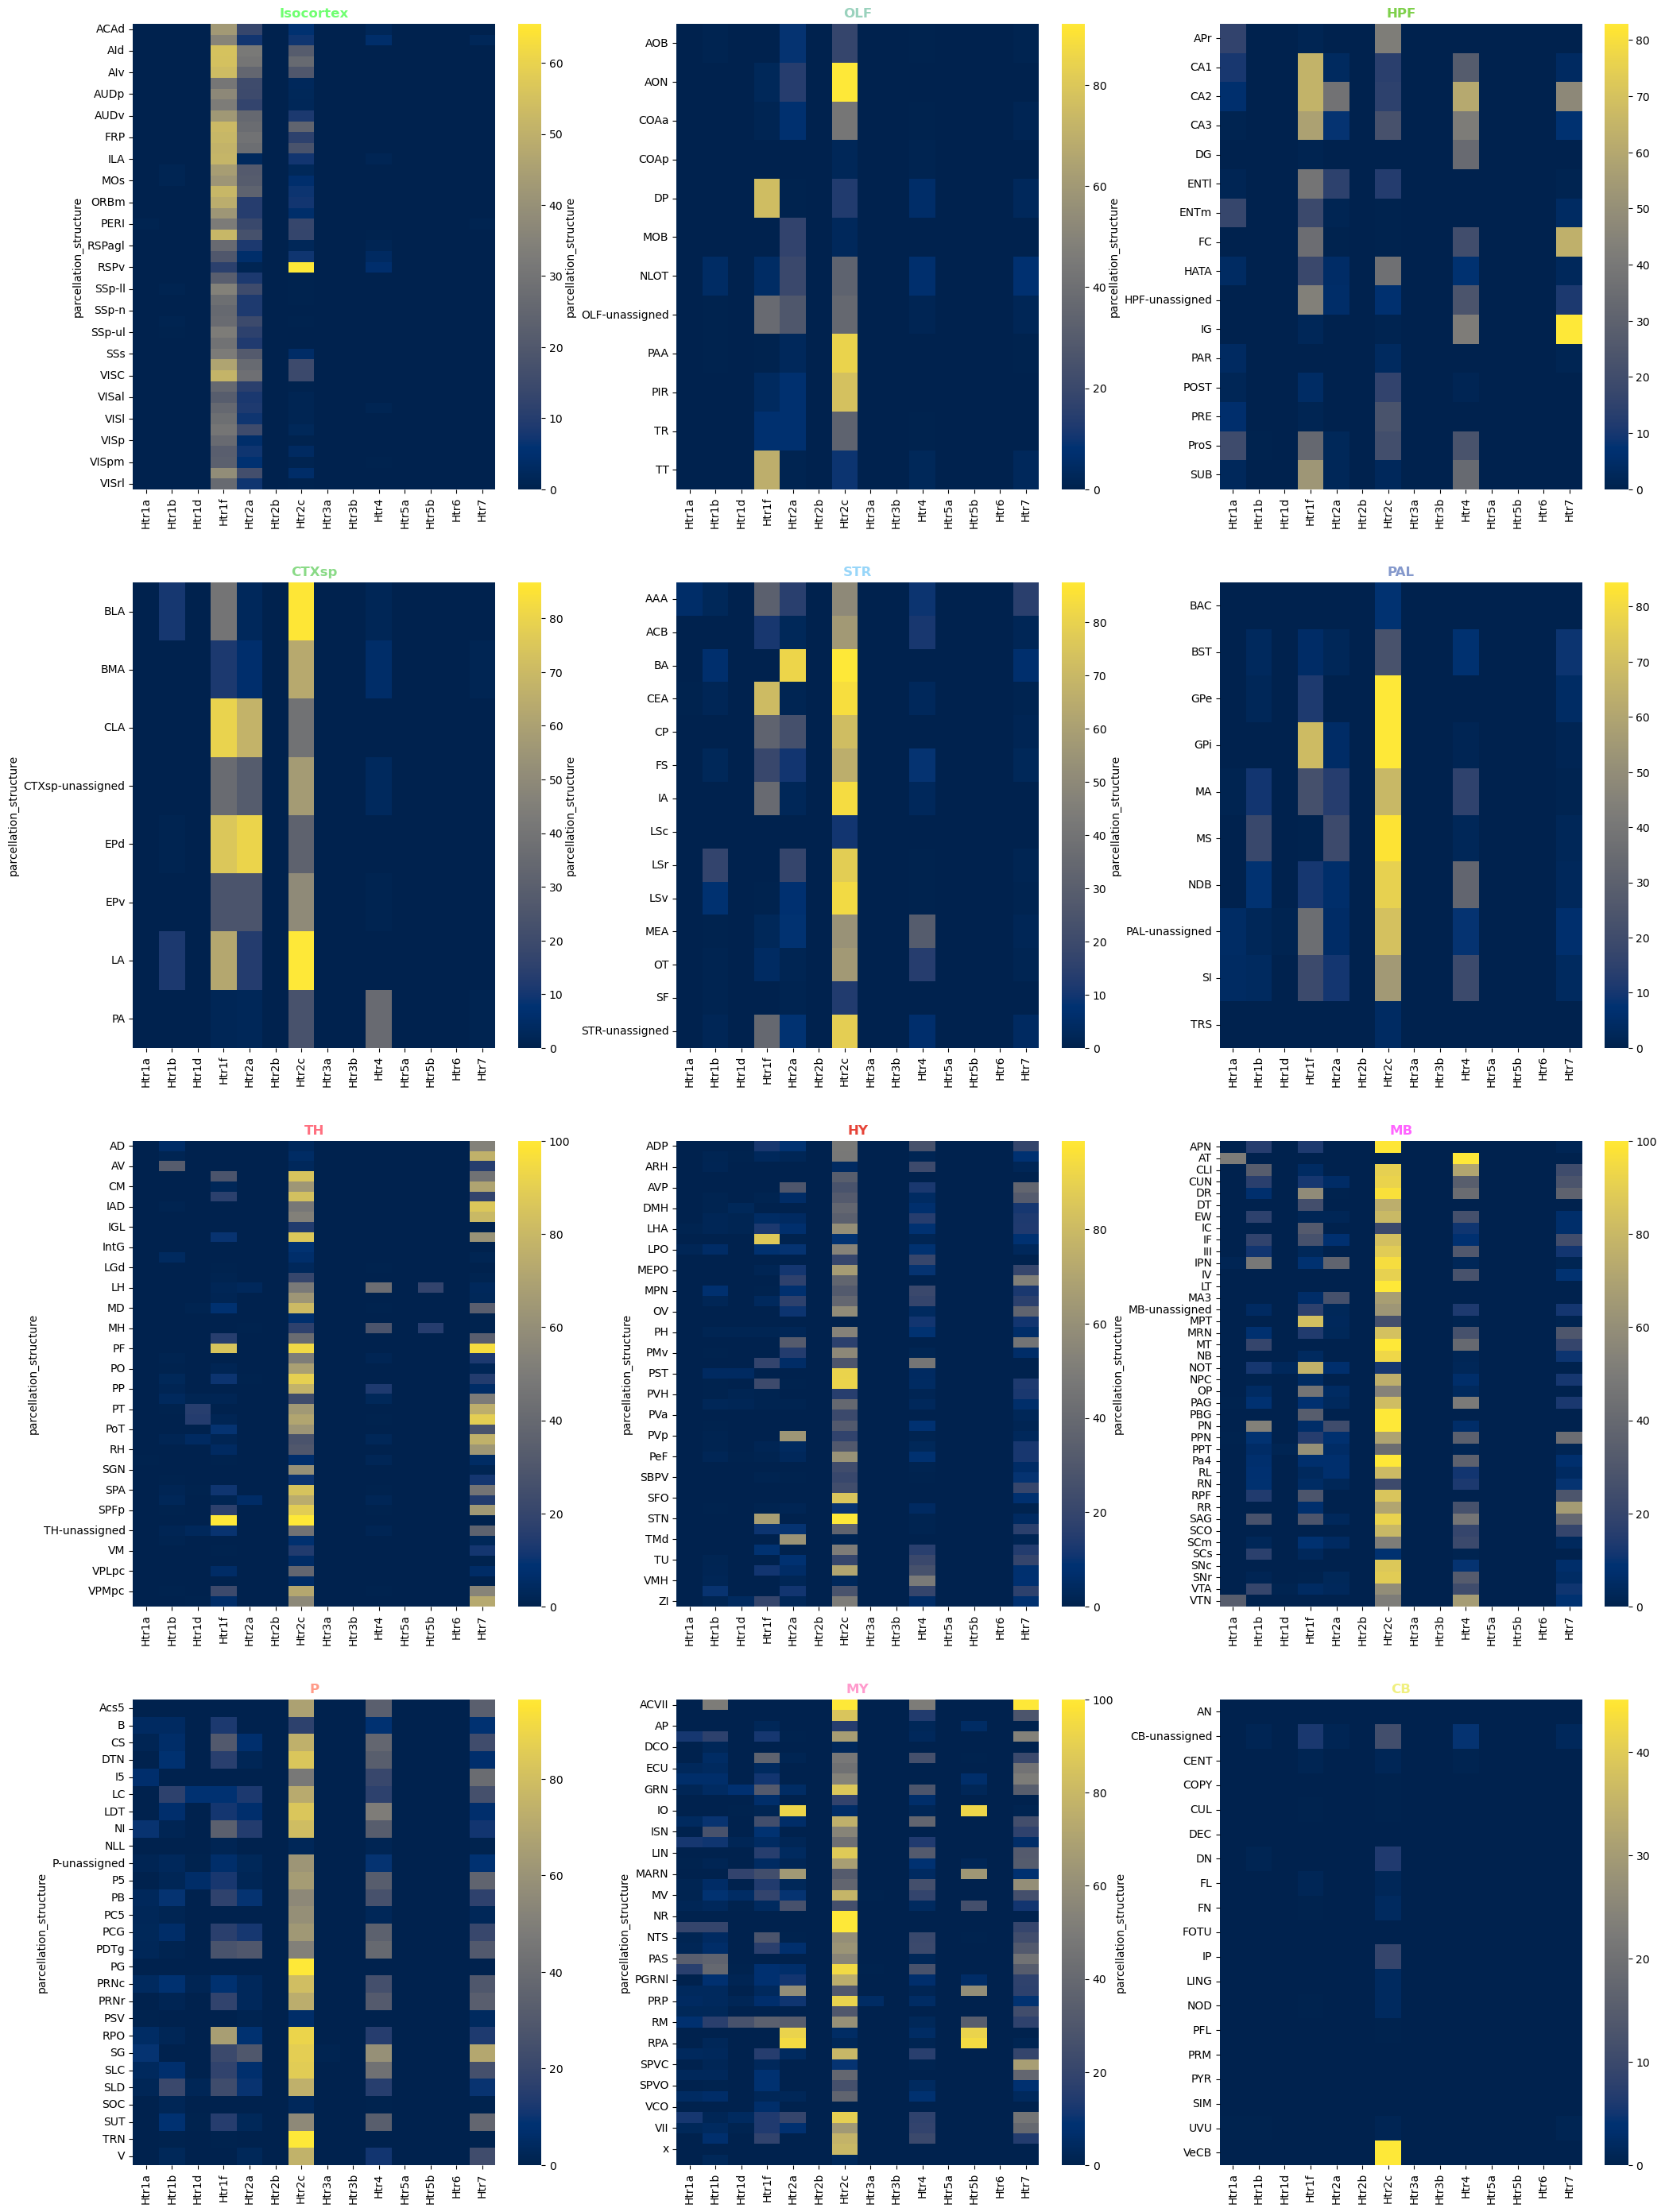

In [58]:


fig, axs = plt.subplots(4,3, figsize=(25,35))

axs_flat = axs.flatten()

for n, reg in enumerate(order_division):
    sns.heatmap(expr_by_region_glut.loc[reg], cmap="cividis", ax=axs_flat[n])
    axs_flat[n].set_title(reg, color=color_dict[reg], fontsize='large', fontweight='bold')

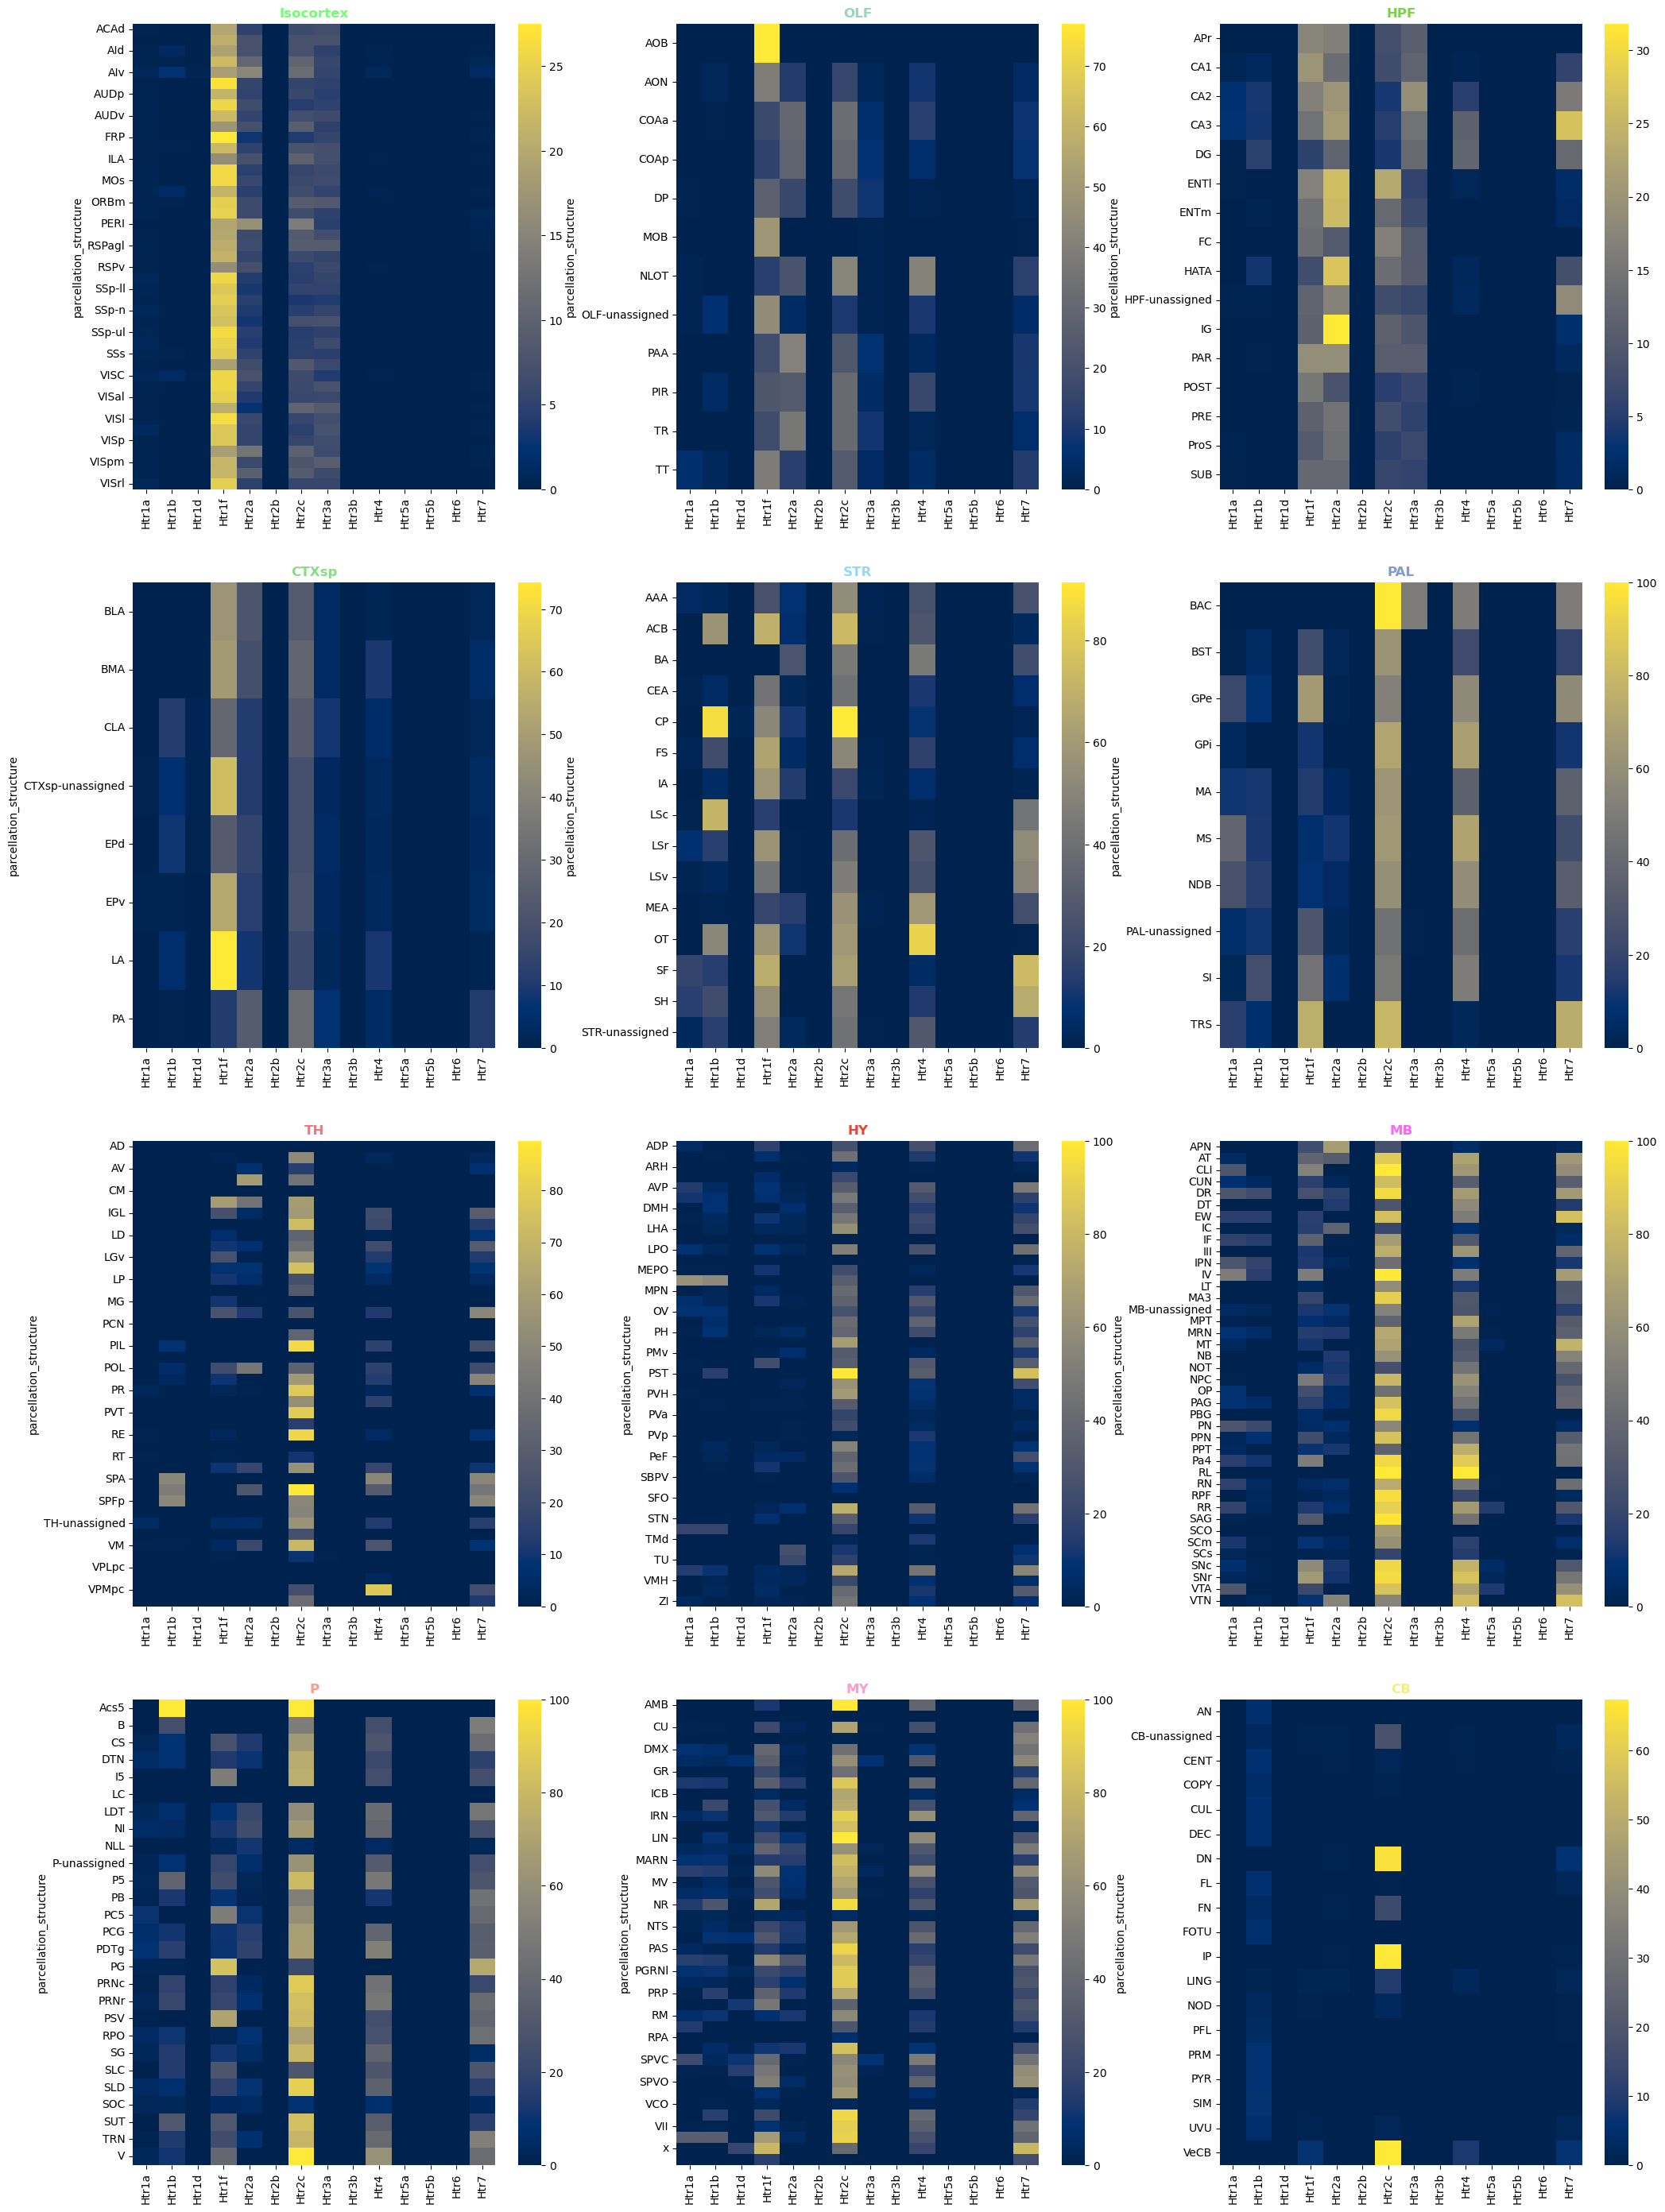

In [59]:
fig, axs = plt.subplots(4,3, figsize=(25,35))

axs_flat = axs.flatten()

for n, reg in enumerate(order_division):
    sns.heatmap(expr_by_region_gaba.loc[reg], cmap="cividis", ax=axs_flat[n])
    axs_flat[n].set_title(reg, color=color_dict[reg], fontsize='large', fontweight='bold')